In [1]:
from commons import *
from libruntimepredictionanalysis import *
from tqdm import tqdm_notebook as tqdm

In [192]:
# read in data
df = pd.read_csv("data/runtimes_all_default_nooutliers.csv")
df["applicationtimeperunit"] = df["applicationtime"] / df["applicationsize"]
df

openmlid  totalsize  fitsize  applicationsize  fitattributes  seed  \
0              3       3196        2             3194             40     0   
1              3       3196        2             3194             40     0   
2              3       3196        2             3194             40     0   
3              3       3196        2             3194             40     0   
4              3       3196        2             3194             40     1   
...          ...        ...      ...              ...            ...   ...   
124492     41991     270912    10000           260912            784     0   
124493     41991     270912    10000           260912            784     0   
124494     41991     270912    10000           260912            784     0   
124495     41991     270912     1000           269912            784     1   
124496     41991     270912    10000           260912            784     1   

       algorithm                                   algorithmoptions  fittime  \
0       bayesnet   -D -Q weka.classifiers.bayes.net.search.local.K2        1   
1       bayesnet     -Q weka.classifiers.bayes.net.search.local.TAN        1   
2       bayesnet  -Q weka.classifiers.bayes.net.search.local.Hil...        2   
3       bayesnet  -D -Q weka.classifiers.bayes.net.search.local.TAN        2   
4       bayesnet   -D -Q weka.classifiers.bayes.net.search.local.K2        1   
...          ...                                                ...      ...   
124492       lmt                                                 -R     3601   
124493       lmt                                                 -C     3601   
124494       lmt                                                 -P     3600   
124495       lmt                                                 -C     3600   
124496       lmt                                              -M 64     3600   

        applicationtime  applicationtimeperunit  
0                   1.0                0.000313  
1                   0.0                0.000000  
2                   7.0                0.002192  
3                  36.0                0.011271  
4                   0.0                0.000000  
...                 ...                     ...  
124492              NaN                     NaN  
124493              NaN                     NaN  
124494              NaN                     NaN  
124495              NaN                     NaN  
124496              NaN                     NaN  

[124497 rows x 11 columns]

In [193]:
datasets = sorted(pd.unique(df["openmlid"]))
algorithms = sorted(pd.unique(df["algorithm"]))
classifiers = [a for a in algorithms if not "AS" in a and not "/" in a]
preprocessors = [a for a in algorithms if "AS" in a or "/" in a]
fitsizes = sorted(pd.unique(df["fitsize"]))

# 1. Preliminaries: Classifier Runtime Visualizations

## 1.1. Train- and Prediction/Application times against Trainpoints
Idea: Most algorithms are probably *either* fast in training *or* in predicting. That means that test times of slow-training algorithms are negligibly why prediction-times of slow-predictors can be precisely estimated by training the model an predicting k (k small) instances and interpolating exploiting linearity of total test time.

To this end, we want to know:
* what is, for each classifier, the test time per instance for different train sizes?

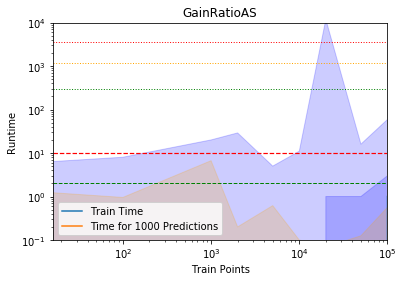

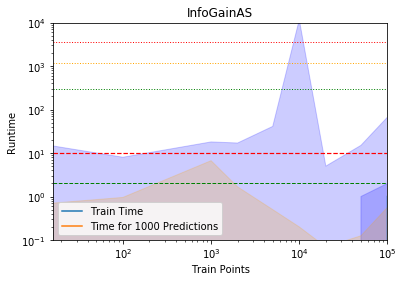

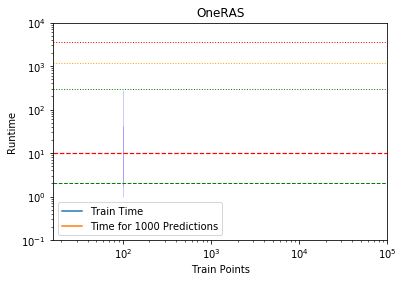

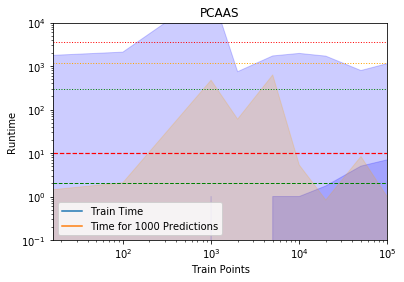

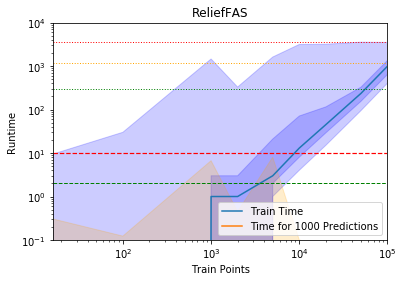

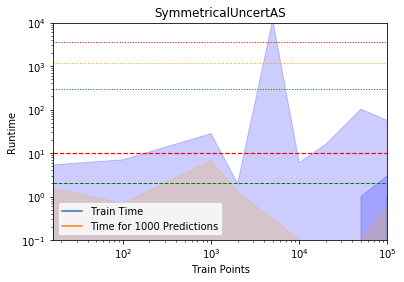

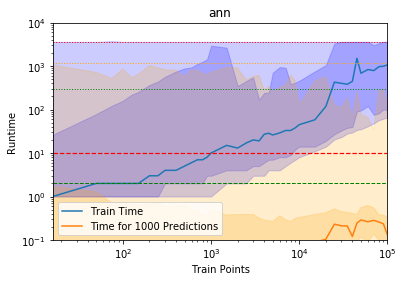

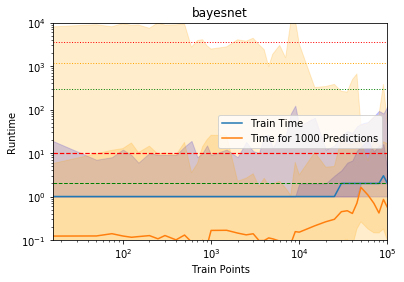

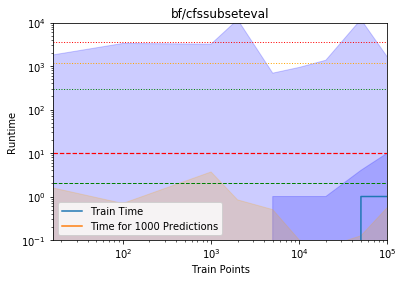

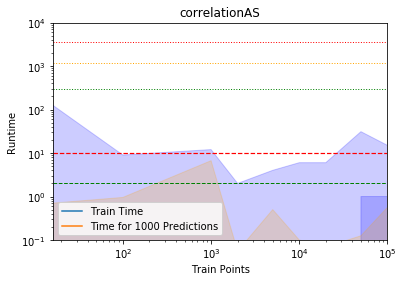

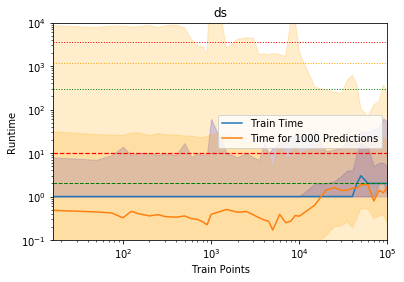

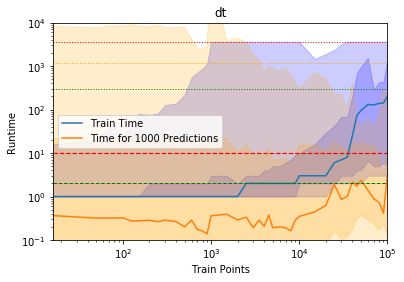

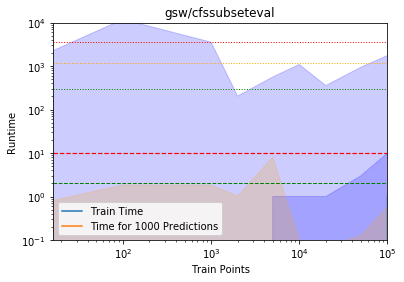

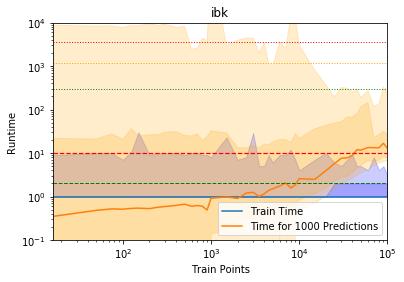

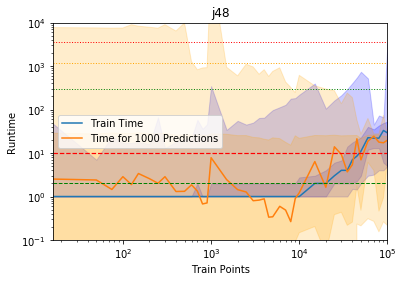

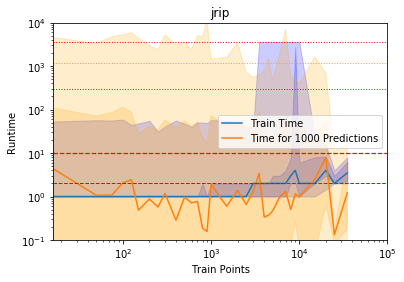

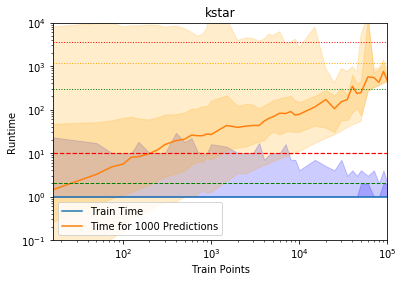

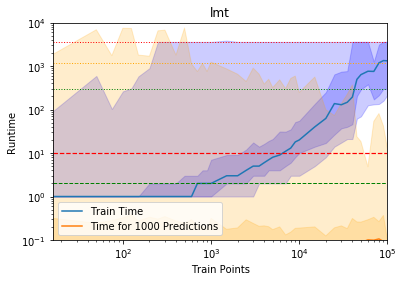

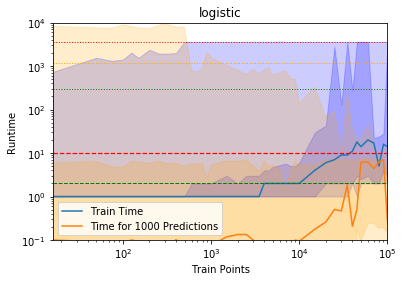

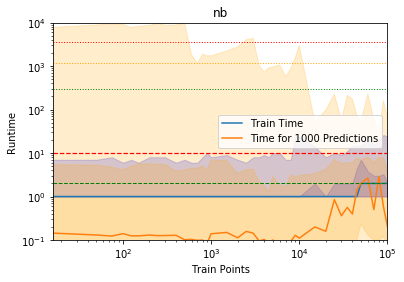

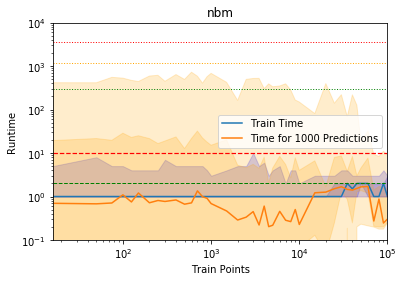

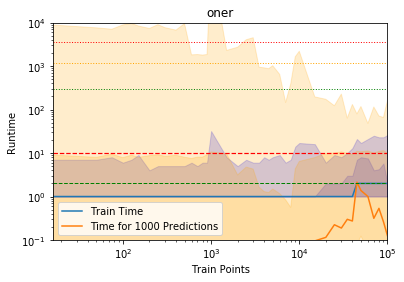

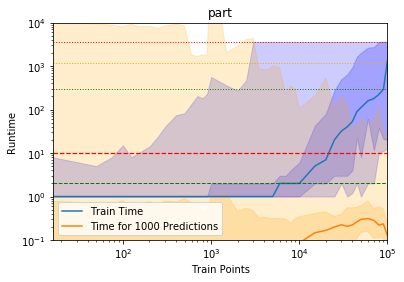

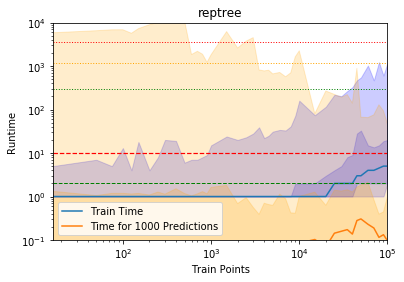

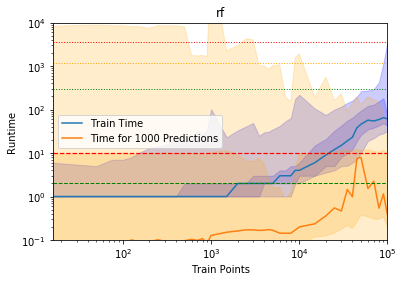

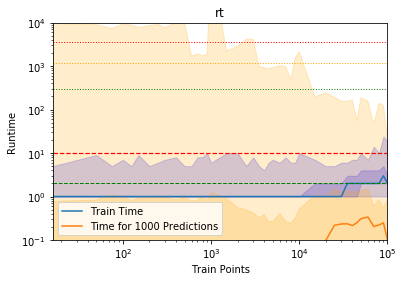

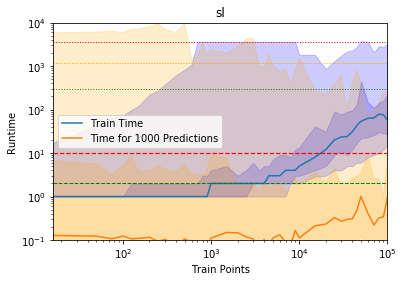

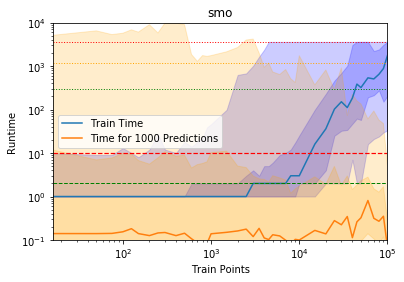

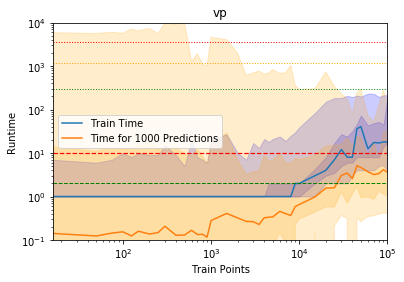

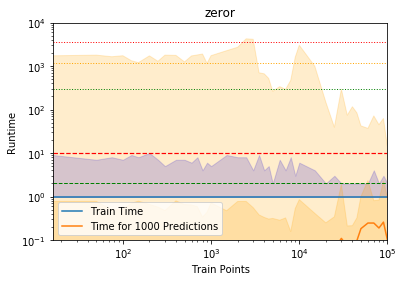

In [11]:
numPredictions = 1000
legend=["Train Time", "Time for " + str(numPredictions) +" Predictions"]
for i, c in enumerate(algorithms):
    cData = df.query("algorithm == '" + c + "'")
    trainpoints = np.unique(cData["fitsize"].values)
    trainpoints = trainpoints[trainpoints >= 10]
    q1aPointsY = []
    q3aPointsY = []
    q1bPointsY = []
    q3bPointsY = []
    medianPointsY = []
    q1aPointsZ = []
    q3aPointsZ = []
    q1bPointsZ = []
    q3bPointsZ = []
    medianPointsZ = []
    validTrainPoints = []
    #pointsY = []
    for tp in trainpoints:
        rData = cData.query("fitsize == " + str(tp))
        y = numPredictions * rData["applicationtimeperunit"]
        y = y[~np.isnan(y)]
        z = rData["fittime"]
        #for i, v in enumerate(y):
        #    print(v)
        if len(y) > 4:
            validTrainPoints.append(tp)
            q1aPointsY.append(np.quantile(y, 0.05))
            q1bPointsY.append(np.quantile(y, 0.25))
            medianPointsY.append(np.median(y))
            q3aPointsY.append(np.quantile(y, 1))
            q3bPointsY.append(np.quantile(y, 0.75))
            
            q1aPointsZ.append(np.quantile(z, 0.05))
            q1bPointsZ.append(np.quantile(z, 0.25))
            medianPointsZ.append(np.median(z))
            q3aPointsZ.append(np.quantile(z, 1))
            q3bPointsZ.append(np.quantile(z, 0.75))
            #print(str(tp) + ": " + str(v))
        #meanPoints.append(np.mean(y))
        #pointsY.append(v)

    plt.figure()
    plt.title(c)# + " (train prediction RMSE quantile for 30s/1m/2m/5m/20m error: " + str(np.round(sp.stats.percentileofscore(metricRMSETrain[:,i], 30), 2)) + "/" + str(np.round(sp.stats.percentileofscore(metricRMSETrain[:,i], 60), 2)) + "/" + str(np.round(sp.stats.percentileofscore(metricRMSETrain[:,i], 120), 2)) + "/" + str(np.round(sp.stats.percentileofscore(metricRMSETrain[:,i], 300), 2)) + "/" + str(np.round(sp.stats.percentileofscore(metricRMSETrain[:,i], 1200), 2)) + ")")
    #plt.boxplot(points, 0, '')
    if len(q1aPointsY) > 0:
        #plt.plot(validTainPoints, q1Points)
        plt.plot(validTrainPoints, medianPointsZ)
        plt.fill_between(validTrainPoints, q1aPointsZ, q3aPointsZ, color="blue",alpha=0.2)
        plt.fill_between(validTrainPoints, q1bPointsZ, q3bPointsZ, color="blue", alpha=0.2)
        plt.plot(validTrainPoints, medianPointsY)
        plt.fill_between(validTrainPoints, q1aPointsY, q3aPointsY, color="orange", alpha=0.2)
        plt.fill_between(validTrainPoints, q1bPointsY, q3bPointsY, color="orange", alpha=0.2)
        plt.axhline(10, color="red", linestyle="--", linewidth="1.2")
        plt.axhline(2, color="green", linestyle="--", linewidth="1")
        plt.axhline(300, color="green", linestyle=":", linewidth="1")
        plt.axhline(1200, color="orange", linestyle=":", linewidth="1")
        plt.axhline(3600, color="red", linestyle=":", linewidth="1")
        #plt.plot(validTainPoints, q3Points)
        #plt.xticks(trainpoints)
        #plt.scatter(trainpoints, meanPoints, color="green")
        #if len(points) > 0:
        plt.xlabel("Train Points")
        plt.ylabel("Runtime")
        plt.xscale("log")
        plt.xlim([16,100000])
        plt.ylim([0.1,10000])
        plt.yscale("log")
        plt.legend(legend)
    plt.show()
    plt.close()
        

**Conclusion**: The above figures suggest that the following classifiers have, even for large data, negligible train time (never more than 10s) and ...
* ... prediction time increasing with more train datapoints:
 * ibk
 * kstar
* ... constant prediction time:
 * nb
 * nbm
 * rt
 
The following algorithms have high train time (*all* of them have a prediction time that is independent of the used train data):
* ann (great train time predictability)
* bn (poor train time predictability)
* ds (poor train time predictability)
* dt (great train time predictability)
* j48 (great train time predictability)
* jrip (medium train time predictability)
* lmt (medium train time predictability)
* logistic (poor train time predictability)
* oner (medium train time predictability)
* part (medium train time predictability)
* rf (poor train time predictability)

## 1.2. Runtimes against (a) train size AND (b) number of numeric features

In [9]:
overviews = {}

In [58]:
def getRuntimePlotData(algorithm):
    attributeForAttributes = "fitattributes"
    classifierData = df.query("algorithm =='" + algorithm + "'")
    trainpoints = np.unique(classifierData["fitsize"])
    attributes = np.unique(classifierData[attributeForAttributes])
    
    #plt.figure()
    traintimes = np.empty((len(trainpoints), len(attributes)), dtype=object)
    testtimes = np.empty((len(trainpoints), len(attributes)), dtype=object)
    for i, tp in enumerate(trainpoints):
        for j, at in enumerate(attributes):
            vals = classifierData.query("fitsize == " + str(tp) + " and " + attributeForAttributes + " == " + str(at))
            if len(vals) > 0:
                traintimes[i][j] = vals["fittime"].values
                testtimes[i][j] = vals["applicationtimeperunit"].values
            else:
                traintimes[i][j] = float('nan')
                testtimes[i][j] = float('nan')
    return traintimes, testtimes

def tableMean(table):
    m = table.shape[0]
    n = table.shape[1]
    out = np.zeros((m, n))
    for i in range(m):
        for j in range(n):
            out[i,j] = np.median(table[i,j])
    return out

In [15]:
for alg in tqdm(algorithms):
    overviews[alg] = getRuntimePlotData(alg)

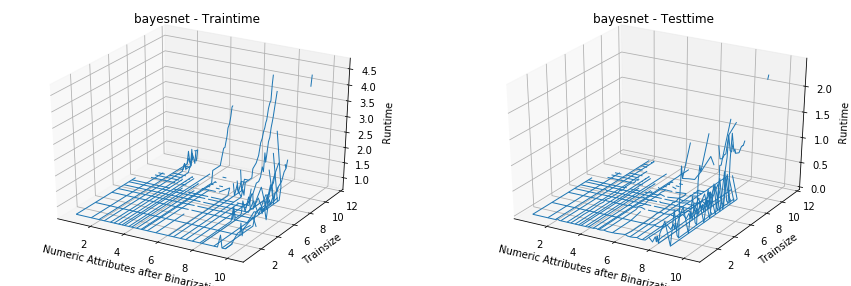

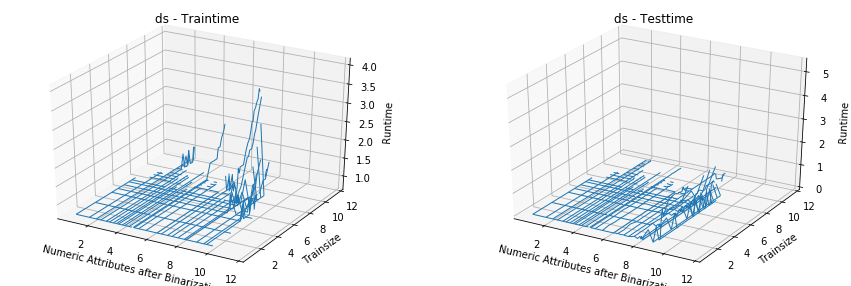

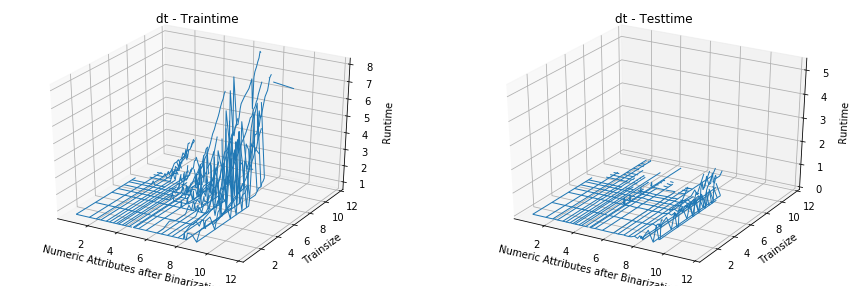

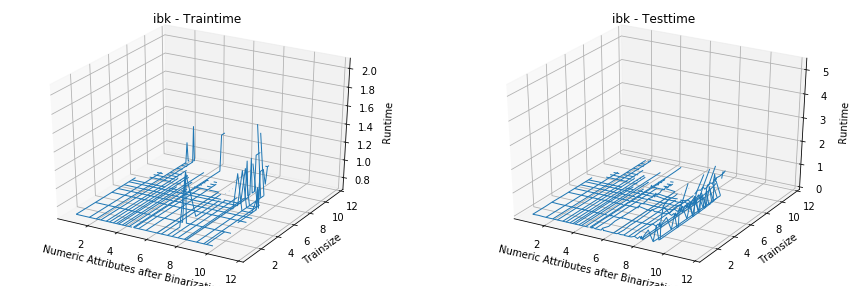

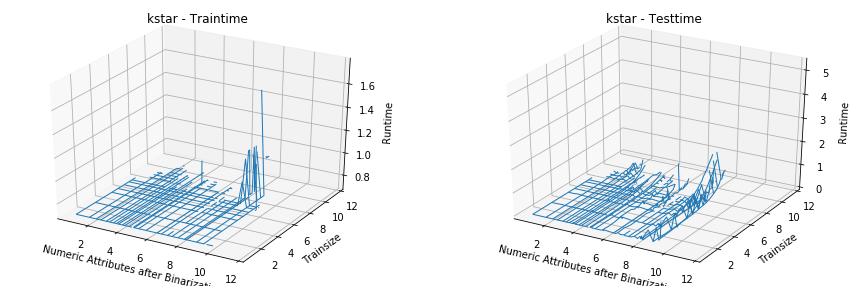

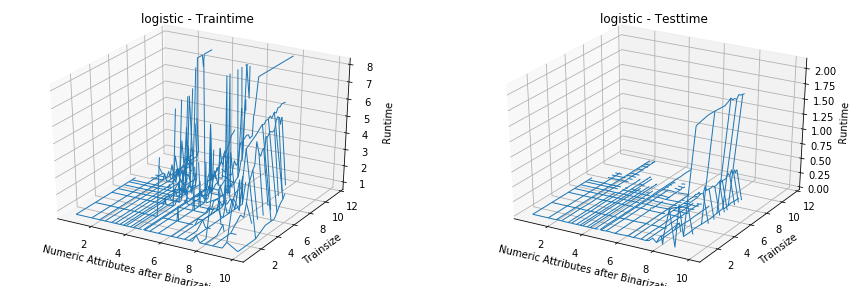

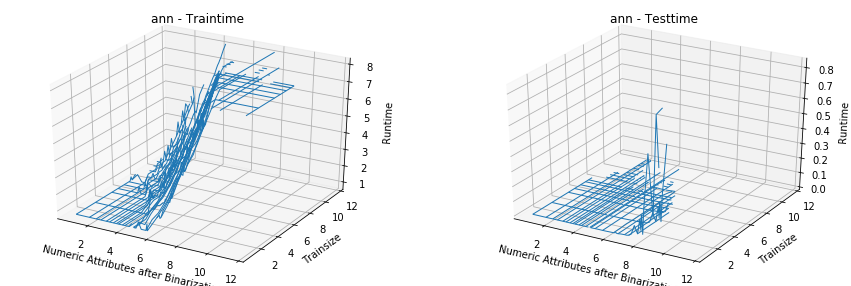

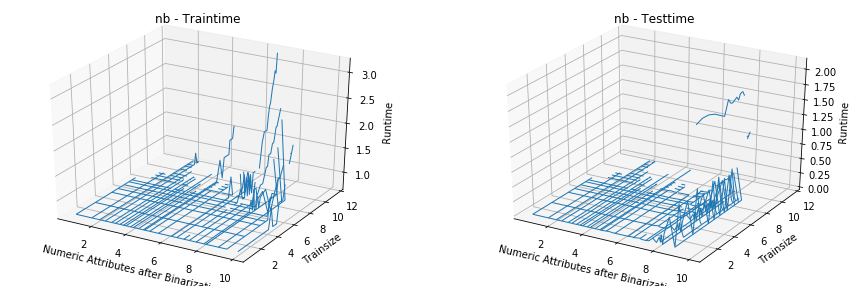

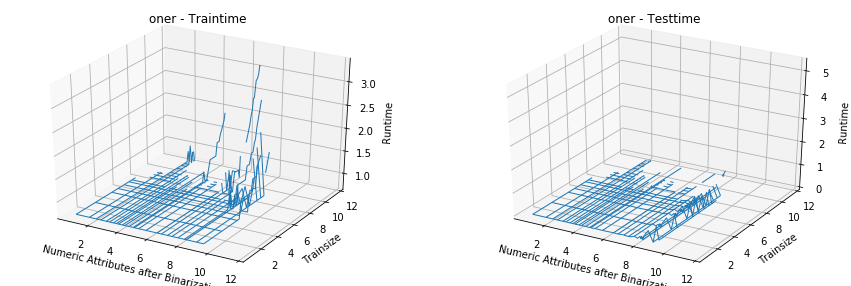

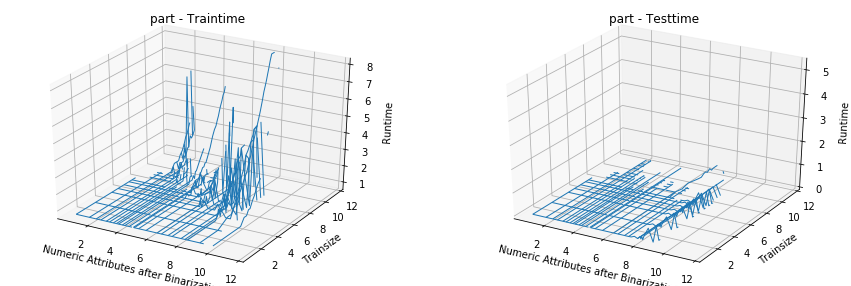

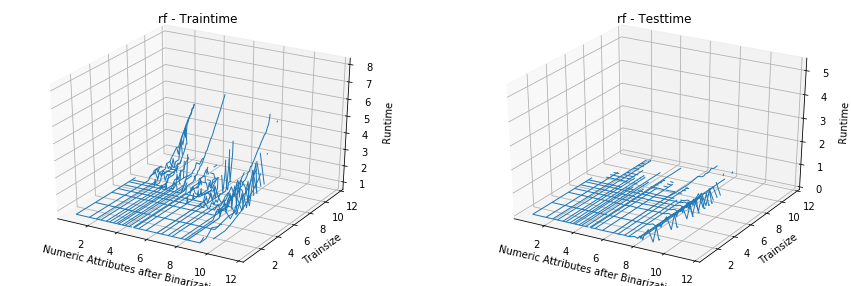

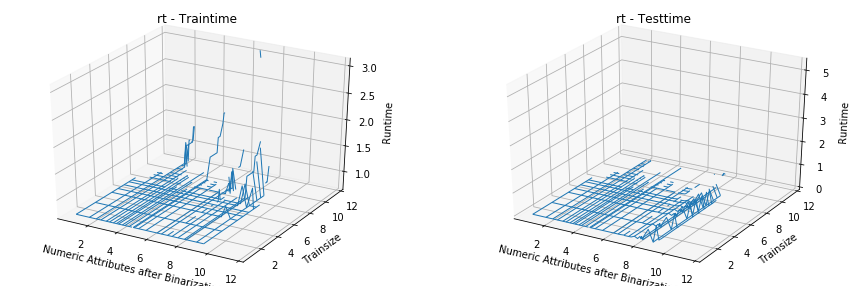

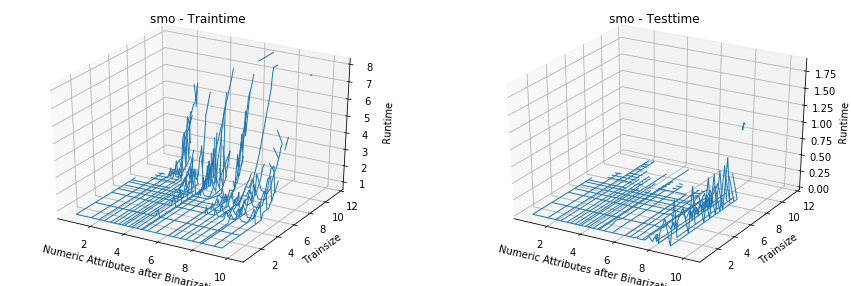

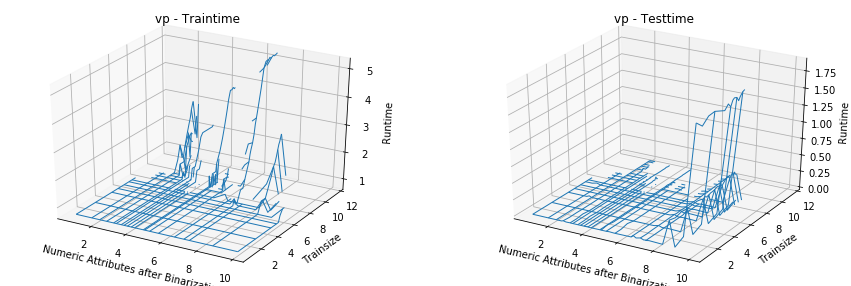

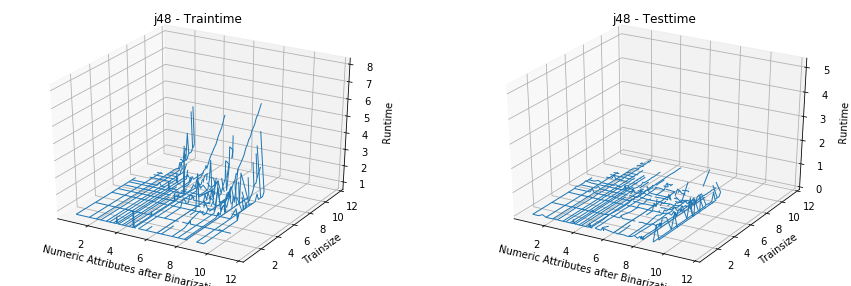

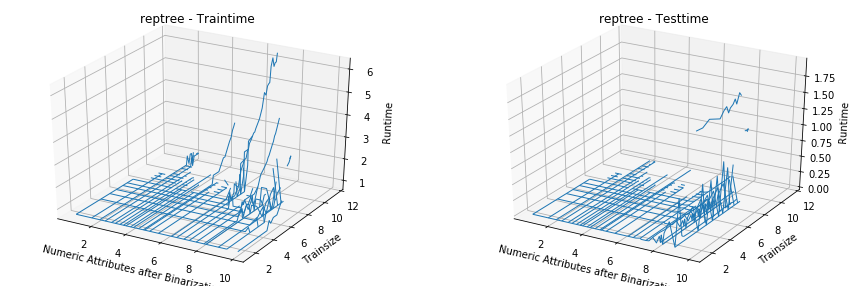

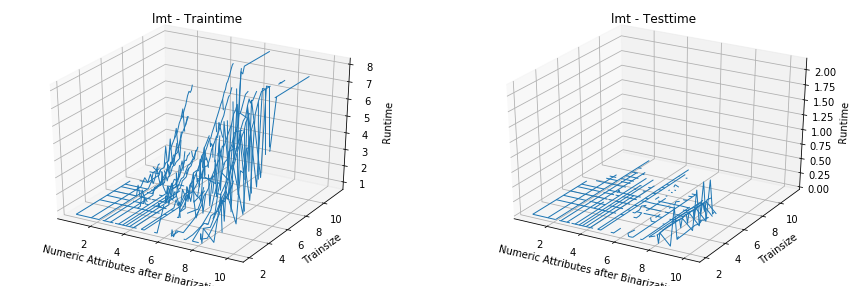

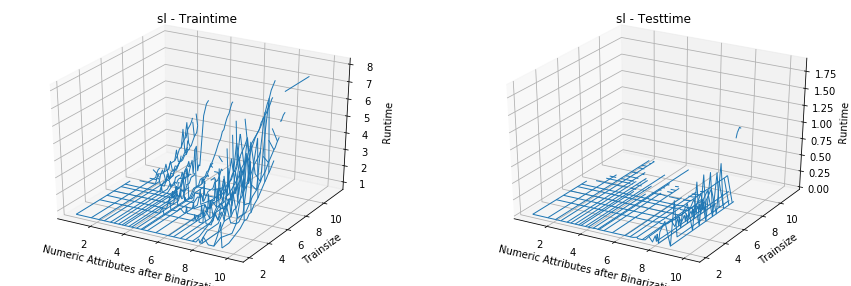

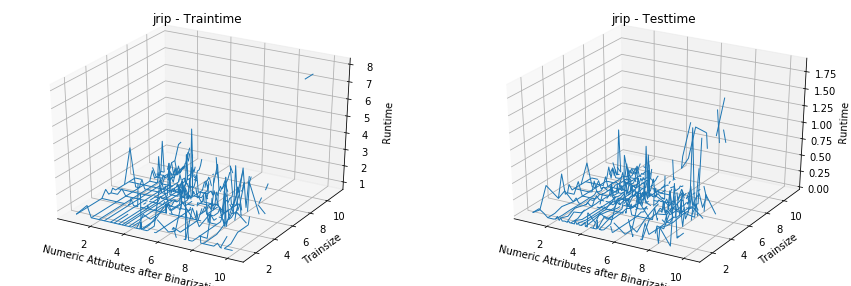

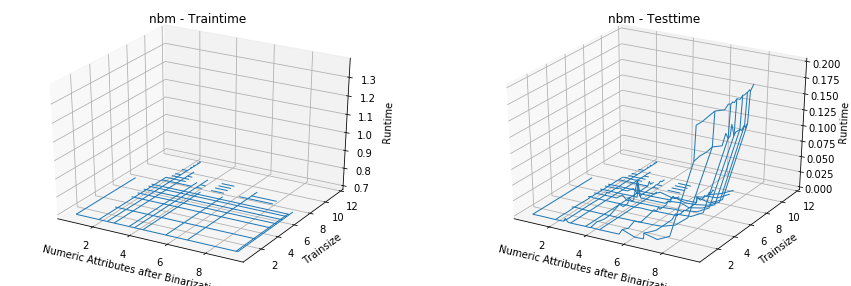

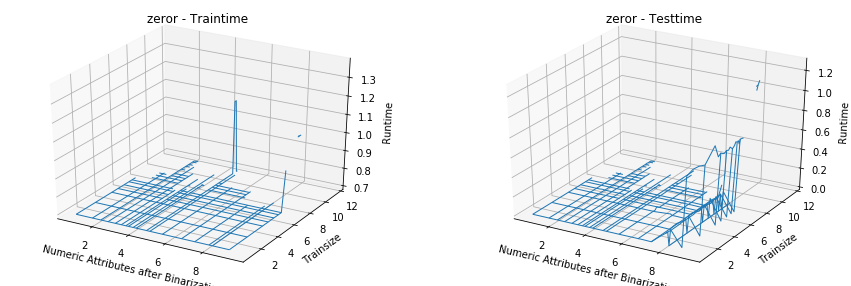

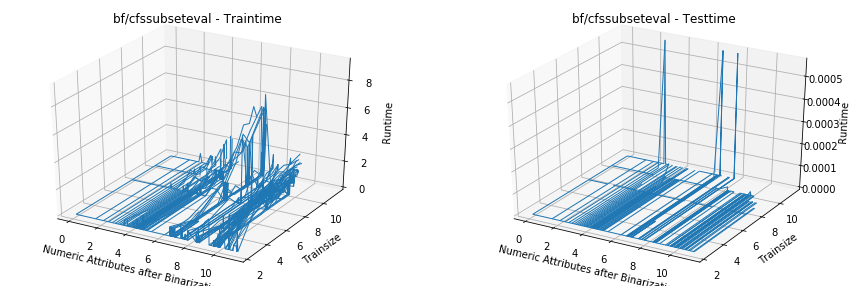

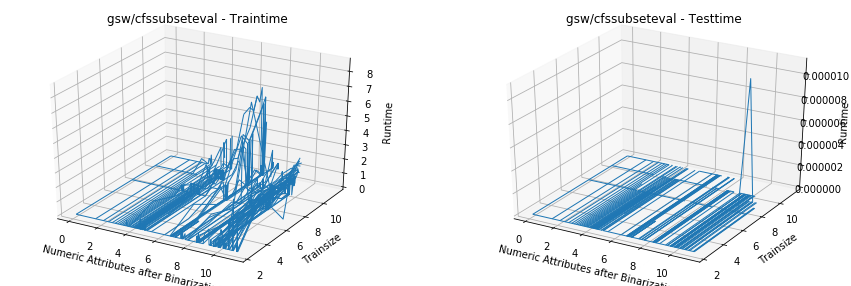

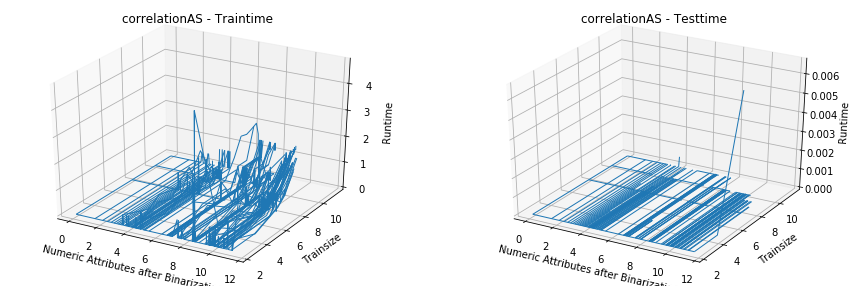

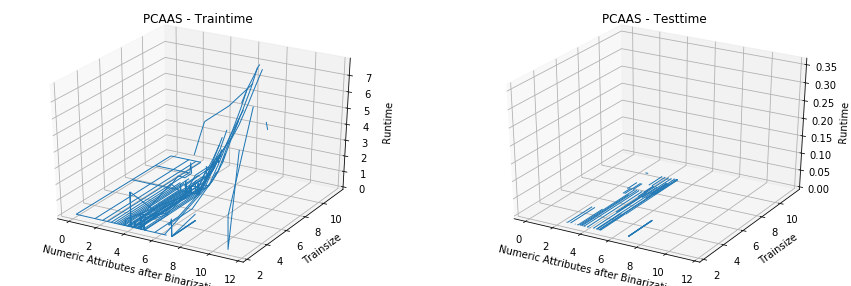

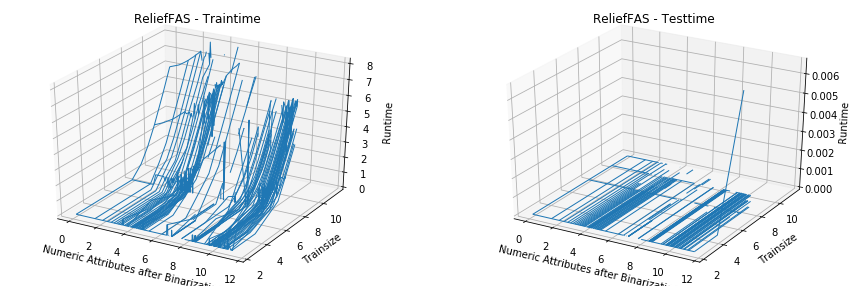

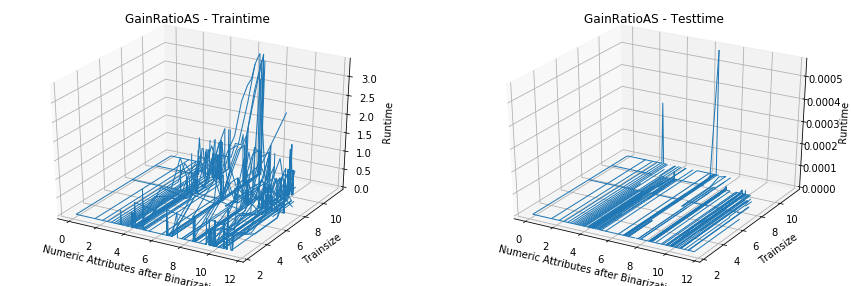

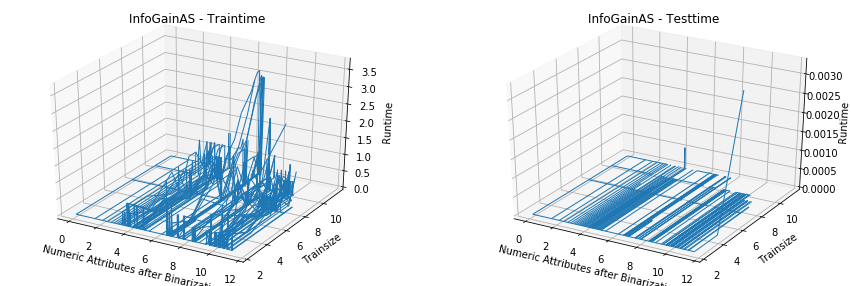

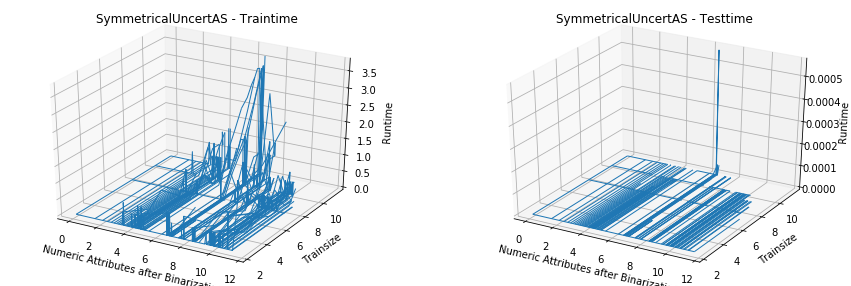

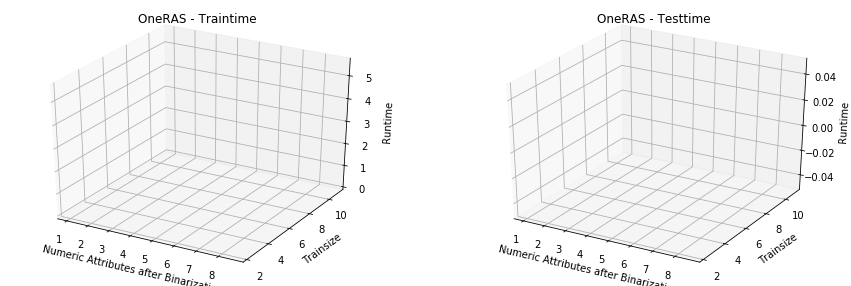

In [20]:
for k in overviews:
    classifierData = df.query("algorithm =='" + k + "'")
    trainpoints = np.log(np.unique(classifierData["fitsize"]))
    attributeForAttributes = getAttributeForAttributesOfAlgorithm(k)
    attributes = np.log(np.unique(classifierData["fitattributes"]))
    
    traintimes = tableMean(overviews[k][0])
    testtimes = tableMean(overviews[k][1])
    
    X, Y = np.meshgrid(attributes, trainpoints)
    #adjustLimits(projection, ax)
    fig = plt.figure()
    for i, table in enumerate([traintimes, testtimes]):
        ax = fig.add_subplot(1, 2, (i + 1), projection='3d')
        fig.set_figheight(5)
        fig.set_figwidth(15)
        logtable = (table + 1).astype('float32')
        logtable = np.log(logtable)
        ax.plot_wireframe(X, Y, logtable, rstride=3, cstride=3, linewidth=1, antialiased=True)
        ax.set_xlabel('Numeric Attributes after Binarization')
        ax.set_ylabel('Trainsize')
        ax.set_zlabel('Runtime')
        ax.set_title(k + " - " + ("Traintime" if i == 0 else "Testtime"))
    plt.show()
    plt.close()

# 2. Dispersion (Difficulty of the Learning Problem)

In [147]:
## FIRST STEP: Determining the dispersion (and "non-determinism") in the observed data
## Compute, for each classifier, the average variance in the execution times
import scipy
mstds = {}
stds = {}
pbar = tqdm(total = len(algorithms) * len(datasets))
for a in algorithms:
    for d in datasets:
        cdf = df.query("algorithm == '" + a + "' and openmlid == " + str(d))
        combinations = cdf[["fitsize", "fitattributes"]].drop_duplicates()
        observations = []
        for combo in combinations.values:
            runs = cdf.query("fitsize == '" + str(combo[0]) + "' and fitattributes == " + str(combo[1]))[["fittime"]]
            var = np.std(runs.values)
            observations.append(var)
        pbar.update(1)
    mstds[a] = scipy.stats.trim_mean(observations, 0.05)
    stds[a] = np.std(cdf[["fittime"]].values)
pbar.close()

/home/felix/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/felix/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/felix/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


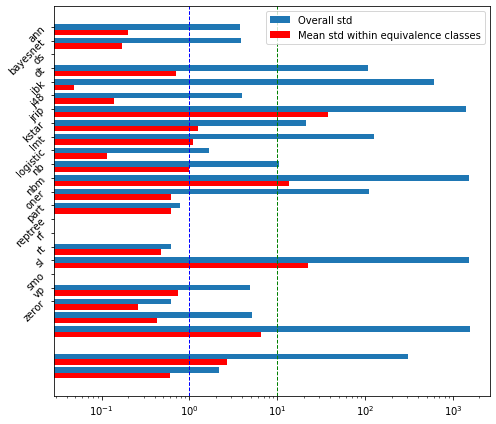

In [149]:
plt.figure(figsize=(7,6))
ind = np.arange(len(stds))
width=0.4
plt.barh(ind, list(stds.values()), width, label="Overall std")
plt.barh(ind + width, list(mstds.values()), width, color="red", label="Mean std within equivalence classes")
plt.yticks(range(len(classifiers)), list(classifiers), rotation=45)
plt.xscale("log")
plt.gca().invert_yaxis()
plt.axvline(1, color="blue", linestyle="--", linewidth="1")
plt.axvline(10, color="green", linestyle="--", linewidth="1")
plt.legend()
plt.tight_layout()
plt.savefig("basealg-stds.pdf")
plt.show()

## 3. Identification of Suitable Features to predict runtimes

In [5]:
candidates = ['numattributes', 'numlabels',
              #'numnumericattributes',
       #'numsymbolicattributes',
        'numberofcategories',
        'attributestocover50pctvariance'
       #'attributestocover90pctvariance', 'attributestocover95pctvariance',
       #'attributestocover99pctvariance'
        ]

basefeatures = ['fitsize', 'fitattributes']
#basefeatures.append(can)
#

In [ ]:
updateGTPredictionPairSeries(datasets, classifiers, df, "forest", range(3), [1, 2, 4, 8, 16, 32, 64, 200, 300, 400, 500, 600, 700, 800, 900], basefeatures, ["()"], fitsizes)

The classifier space has no values for openmlid 3
The classifier space has no values for openmlid 3
The classifier space has no values for openmlid 3
The classifier space has no values for openmlid 3
The classifier space has no values for openmlid 3
The classifier space has no values for openmlid 3
The classifier space has no values for openmlid 3
The classifier space has no values for openmlid 3
The classifier space has no values for openmlid 3
The classifier space has no values for openmlid 3
The classifier space has no values for openmlid 3
The classifier space has no values for openmlid 3
The classifier space has no values for openmlid 3
The classifier space has no values for openmlid 3
The classifier space has no values for openmlid 3
The classifier space has no values for openmlid 3
The classifier space has no values for openmlid 3
The classifier space has no values for openmlid 3
The classifier space has no values for openmlid 3
The classifier space has no values for openmlid 3


The classifier space has no values for openmlid 22
The classifier space has no values for openmlid 22
The classifier space has no values for openmlid 22
The classifier space has no values for openmlid 23
The classifier space has no values for openmlid 23
The classifier space has no values for openmlid 23
The classifier space has no values for openmlid 23
The classifier space has no values for openmlid 23
The classifier space has no values for openmlid 23
The classifier space has no values for openmlid 23
The classifier space has no values for openmlid 23
The classifier space has no values for openmlid 23
The classifier space has no values for openmlid 23
The classifier space has no values for openmlid 23
The classifier space has no values for openmlid 23
The classifier space has no values for openmlid 23
The classifier space has no values for openmlid 23
The classifier space has no values for openmlid 23
The classifier space has no values for openmlid 23
The classifier space has no val

The classifier space has no values for openmlid 32
The classifier space has no values for openmlid 32
The classifier space has no values for openmlid 32
The classifier space has no values for openmlid 32
The classifier space has no values for openmlid 32
The classifier space has no values for openmlid 32
The classifier space has no values for openmlid 32
The classifier space has no values for openmlid 36
The classifier space has no values for openmlid 36
The classifier space has no values for openmlid 36
The classifier space has no values for openmlid 36
The classifier space has no values for openmlid 36
The classifier space has no values for openmlid 36
The classifier space has no values for openmlid 36
The classifier space has no values for openmlid 36
The classifier space has no values for openmlid 36
The classifier space has no values for openmlid 36
The classifier space has no values for openmlid 36
The classifier space has no values for openmlid 36
The classifier space has no val

**TODO**: Checke für alle subsets der aktuellen features auf 10 datensätzen mit 5 classifiern, wie gut die performance ist, um die idealen Feature zu bestimmen. Das wären 10 * 5 * 2^10 = 50*1024 = 50000 Auswertungen.

Wahrscheinlich zu viel. Wir könnten erstmal bestimmte Teilmengen probieren (erstmal nur einzelne features, dann die zweier-Kombinationen, dann dreier-Kombinationen). Das wären dann 50 * (10 + 55) = 3000 Auswertungen.

Das sieht machbar aus. Trotzdem gestaffelt vorgehen: Erstmal NUR die mit einem feature.

In [41]:
anDF = pd.read_csv("data/workdata/runtime_predictions.csv")

In [44]:
featureCombos = pd.unique(anDF["basefeatures"])
numRows = len(datasets[0:10]) * len(classifiers[0:5])
M = np.zeros((numRows, len(featureCombos)))
row = 0
for d in datasets[0:10]:
    for c in classifiers[0:5]:
        fDF = anDF.query("openmlid == " + str(d) + " and algorithm == '" + c + "' and trainpoints_algorithm == '100'")
        if len(fDF) > 0:
            gt = list(map(float, fDF.query("recordtype == 'traintime_gt'").iloc[0]["entries"].split(";")))
            col = 0
            for fc in featureCombos:
                expDF = fDF.query("basefeatures == '" + fc.replace("'", "\\'") + "' and recordtype == 'traintime_pr'")
                predictionsForSeeds = expDF["entries"]
                vals = []
                for pred in predictionsForSeeds:
                    predAsNumbers = list(map(float, pred.split(";")))
                    vals.append(RDIST(gt, predAsNumbers))
                M[row][col] = np.mean(vals)
                col += 1
            row += 1

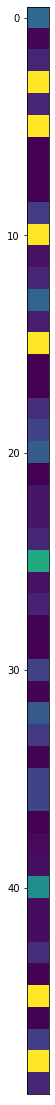

In [45]:
import matplotlib.pyplot as plt

# what is the train and test time of the classifiers on different datasets for 70/30 splits?
fig, ax = plt.subplots(1, 1, figsize=(20,20))
a = ax
im = a.imshow(M, cmap='viridis', vmin=0, vmax=1)
a.set_xticks(np.arange(len(featureCombos) - 1))
a.set_xticklabels(featureCombos, rotation=90)
pass

**Conclusion**: The above experiments strongly suggest that the best is **only to use two** features:
* number of instances
* number of attributes after binarization

This is even better than using a strict superset of these features (even with than 10k training points!)!

In [46]:
import numpy as np
import numpy.ma as ma
import scipy as sp
import pandas as pd
import sklearn as sk
import itertools
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import ARDRegression
import random
import os.path
from os import path
from itertools import chain, combinations
from commons import *
from tqdm import tqdm_notebook as tqdm

########################
## Feature Expansions ##
########################
def expandMult(arr):
    numAttributes = arr.shape[1]
    numPairs = int(sp.special.binom(numAttributes, 2))
    expansion = np.empty((arr.shape[0], numPairs))
    c = 0
    for i in range(numAttributes):
        for j in range(i):
            v = arr[:,i] * arr[:,j]
            expansion[:, c] = v
            c += 1
    return np.concatenate((arr, expansion), axis=1)

def expandPower(arr, exp):
    return np.concatenate((arr, np.power(arr, exp)), axis=1)

def expandLog(arr):
    return np.concatenate((arr,  ma.log(arr)), axis=1)

############################
## Classifier Experiments ##
############################
def getLearnFile(algorithm, openmlids=[]):
    regressionFile = "learnfile-" + algorithm + ".csv"
    if not path.exists(regressionFile):
        L = ["forest", "ann", "linear"]
        E = powerset(["log", "pow", "mul"])
        TrSize = np.unique([int(1 + ((i+1)**2.5)) for i in range(50)])
        S = range(10) # seeds
        algorithms = [algorithm]
        C = np.array([x for x in itertools.product(openmlids, algorithms, TrSize, S, E)])
        z = np.zeros(C.shape[0]) - 1
        C = np.column_stack([range(C.shape[0]), C])
        cols = ["reg_id", "openmlid", "classifier", "traindatasize", "seed", "expansions"]
        for learner in L:
            cols.append("mse_" + learner + "_trainruntime_half")
            cols.append("mse_" + learner + "_trainruntime_full")
            cols.append("mse_" + learner + "_testruntime_half")
            cols.append("mse_" + learner + "_testruntime_full")
            C = np.column_stack([C, z, z, z, z])
        exp = pd.DataFrame(C, columns=cols)
        exp.to_csv(regressionFile, index=False)
        return exp
    else:
        return pd.read_csv(regressionFile)

def updateLearnFile(algorithm, results):
    regressionFile = "learnfile-" + algorithm + ".csv"
    df = getLearnFile(algorithm).T ## assume that file exists.
    ## IN THE df OBJECT, line indices correspond to reg_ids
    for i, r in results.iterrows():
        df[r["reg_id"]] = r.values
    df = df.T
    df.to_csv(regressionFile, index=False)
    
def getRegressionInputRepresentation(dataspace, basefeatures, openmlid, algorithm, expansion, target):

    # reduce data only to those that have the desired classifier
    classifierSpace = dataspace.query("algorithm == '" + algorithm + "'")
    if len(classifierSpace.query("openmlid == " + str(openmlid))) == 0:
        raise Exception("The classifier space has no values for openmlid " + str(openmlid))
    classifierSpace = classifierSpace.dropna(subset=[target])
    
    # create features for regression problem
    X = np.nan_to_num(classifierSpace[basefeatures].values)
    if "log" in expansion:
        X = expandLog(X)
    if "pow" in expansion:
        X = expandPower(X, 2)
    if "mul" in expansion:
        X = expandMult(X)
    Y = classifierSpace[[target]].values
    Y = np.log(Y + 1)
    
    indices, cIndices = getIndicesOfRowsForOpenMLId(classifierSpace, openmlid)
    if len(cIndices) == 0:
        raise Exception("No test data selected for openmlid " + str(openmlid))
    
    # create train/test split for regression problem based on a leave-one-out-split (using the openmlid)
    Xtrain = X[indices]
    Ytrain = Y[indices]
    #print("Reducing train data to those that do NOT have openmlid " + str(openmlid) + ". Length: " + str(len(Xtrain)) + "/" + str(len(X)))
    #print(classifierSpace.iloc[indices])
    #print(Xtrain)
    #print(Ytrain)
    
    # reduce test set to those corresponding to half/full dataset (according to targetdssize)
    Xtest = X[cIndices]
    Ytest = Y[cIndices]
    return Xtrain, Ytrain, Xtest, Ytest

### The function runExperiment performs the following three steps:
###
### 1) trains a learner for the train or prediction time (based on the variable $target)
###     - based on all given data for the classifier that does NOT belong to the given openmlid,
###     - deriving features based on the expansion keyword (log, multiplication, polynomial features)
###     - using traindatasize many random samples from that set
### 2) predicts the runtimes on the GIVEN openmlid for the requested train sizes and FULL
###    (refering to the maximum number of training samples for which a ground truth is known)
###
### 3) returns a dictionary with the different sample sizes for which predictions are requested
###    each one consisting of a pair of ground truth values and prediction values
###
### Two targets are possible: "traintime" and "predictiontimeperinstance"
### In both cases, the traindatasize variable refers to the number of instances used for FITTING the algorithm
### The concrete number of instances for which predictions are made is not relevant and not considered.
def runExperiment(dataspace, basefeatures, openmlid, algorithm, learner, traindatasize, expansion, target, samplesizes):
    Xtrain, Ytrain, Xtest, Ytest = getRegressionInputRepresentation(dataspace, basefeatures, openmlid, algorithm, expansion, target)
    
    numInstancesCol = 0 ## num instances are in first column of X
    numInstances = Xtest[:,numInstancesCol]
    if numInstances.size == 0:
        return {}
    
    # now reduce the train set to the specified value
    tIndices = list(range(Xtrain.shape[0]))
    random.shuffle(tIndices)
    trainSizeBefore = len(Xtrain)
    Xtrain = Xtrain[tIndices[:traindatasize]]
    Ytrain = Ytrain[tIndices[:traindatasize]]
    #print("Reducing train data from " + str(trainSizeBefore) + " to " + str(traindatasize) + ". Effective train size: " + str(len(Xtrain)))
    
    # create learner
    if learner == 'forest':
        reg = RandomForestRegressor(n_estimators=100)
    else:
        if learner == "ann":
            reg = sk.neural_network.MLPRegressor(max_iter=1000)
        else:
                if learner == "linear":
                    reg = sk.linear_model.LinearRegression()
                else:
                    raise Exception("Unknown learner " + learner)
            
    
    # train learner
    #print ("Training " + str(reg) + " with " + "\n\t" + str(Xtrain) + "\nand\n\t" + str(Ytrain))
    reg.fit(Xtrain, np.ravel(Ytrain))
  
    # gather predictions for learner
    out = {}
    maxInstances = int(np.max(numInstances))
    for sampleSize in samplesizes:
        #print("GT: " + str(trueRuntimesFull))
        #print("PR: " + str(predRuntimesFull))
        #fullContainsInf = len(np.where(predRuntimesFull == pInf)[0]) > 0 
        #errorRateTrainFull = sk.metrics.mean_squared_error(trueRuntimesFull, predRuntimesFull) if not fullContainsInf else pInf
        if sampleSize == "full":
            sampleSize = maxInstances
        relevantIndices = np.where(numInstances == sampleSize)[0]
        if len(relevantIndices) == 0:
            out[sampleSize] = ([], [])
        else:
            XtestSampleSize = Xtest[relevantIndices, :].reshape(relevantIndices.size,Xtest.shape[1])
            YtestSampleSize = Ytest[relevantIndices, :].reshape(relevantIndices.size,1)
            out[sampleSize] = (np.ravel(np.exp(YtestSampleSize)), np.exp(reg.predict(XtestSampleSize)))
        if sampleSize == maxInstances:
            out["full"] = out[sampleSize]
    return out

# This is to recover runtime predictions and ground truths from the archive.
def getGTPredictionPairSeries(learner, basefeatures, expansions, trainpoints):
    serializedDF = pd.read_csv("data/workdata/runtime_predictions.csv").query("learner == '" + str(learner) + "' and basefeatures == '" + str(basefeatures).replace("'", "\\'").replace(",", ";") + "' and expansions == '" + str(expansions) + "' and trainpoints_algorithm == 'full' and trainpoints_learner == " + str(trainpoints))
    datasets = list(pd.unique(serializedDF["openmlid"]))
    classifiers = list(pd.unique(serializedDF["algorithm"]))
    seeds = list(pd.unique(serializedDF["seed"]))
    trainGTPredictionPairs = np.empty((len(datasets), len(classifiers)), dtype=object)
    testGTPredictionPairs = np.empty((len(datasets), len(classifiers)), dtype=object)
    pbar = tqdm(total=len(datasets) * len(classifiers) * len(seeds))
    for i, ds in enumerate(datasets):
        for j, c in enumerate(classifiers):
            if trainGTPredictionPairs[i][j] != None:
                raise Exception("ALREADY HAVE VALUES")
            trainVals = []
            testVals = []
            for seed in seeds:
                pbar.update(1)
                relevantData = serializedDF.query("openmlid == " + str(ds) + " and algorithm == '" + str(c) + "' and seed == " + str(seed))
                if len(relevantData) > 0:
                    if len(relevantData) >= 4:
                        trainGT = np.array(relevantData.query("recordtype == 'traintime_gt'")["entries"].values[0].split(";")).astype('float64')
                        trainPR = np.array(relevantData.query("recordtype == 'traintime_pr'")["entries"].values[0].split(";")).astype('float64')
                        testGT = np.array(relevantData.query("recordtype == 'predictiontime_gt'")["entries"].values[0].split(";")).astype('float64')
                        testPR = np.array(relevantData.query("recordtype == 'predictiontime_pr'")["entries"].values[0].split(";")).astype('float64')
                        if len(trainGT) != len(trainPR):
                            raise Exception("GT and PR of traintimes have different length!")
                        if len(testGT) != len(testPR):
                            raise Exception("GT and PR of prediction times have different length!")
                        trainVals.append((trainGT, trainPR))
                        testVals.append((testGT, testPR))
            trainGTPredictionPairs[i][j] = trainVals
            testGTPredictionPairs[i][j] = testVals
    pbar.close()
    return datasets, classifiers, trainGTPredictionPairs, testGTPredictionPairs

def updateGTPredictionPairSeries(datasets, algorithms, mfdf, learner, seeds, trainpoints, basefeatures, expansions, sampleSizes):
    predictionsFile = "data/workdata/runtime_predictions.csv"
    serializedDF = pd.read_csv(predictionsFile)
    interrupted = False
    t = len(algorithms) * len(datasets) * len(seeds) * len(trainpoints) * len(expansions)
    k = 0
    #print("Total number of steps: " + str(t))
    pbar = tqdm(total=t)
    itsSinceLastSave = 0
    basefeaturesStr = str(basefeatures).replace(",", ";")
    for ds in datasets:
        for a in algorithms:
            for exp in expansions:
                for tp in trainpoints:
                    observedFail = False
                    for seed in seeds:
                        try:
                            k += 1
                            pbar.update(1)
                            if observedFail:
                                continue
                            #print("Learning model for " + str(ds) + "/" + c + " with seed " + str(seed) + " on " + str(tp) + " and expansions " + str(exp) + " (" + str(np.round(100 * k/t, 2)) + "%)")
                            
                            excerpt = serializedDF.query("openmlid == " + str(ds) + " and algorithm == '" + a + "' and learner == '" + learner + "' and trainpoints_learner == " + str(tp) + " and basefeatures == \"" + basefeaturesStr + "\" and expansions == '" + str(exp) + "' and seed == " + str(seed))
                            exists = len(excerpt) > 0
                            
                            if exists:
                                pass#print("Skipping due to existence")
                            else:
                                train_results = runExperiment(mfdf, basefeatures, ds, a, learner, tp, exp, "fittime", sampleSizes)
                                prediction_results = runExperiment(mfdf, basefeatures, ds, a, learner, tp, exp, "applicationtimeperunit", sampleSizes)
                 
                                # update the dataframe
                                #if exists:
                                #    serializedDF.loc[excerpt.query("recordtype == 'traintime_gt'").index.values[0]] = [ds, c, seed, learner, tp, str(exp), "traintime_gt", implode(train_results[0], ";")]
                                #    serializedDF.loc[excerpt.query("recordtype == 'traintime_pr'").index.values[0]] = [ds, c, seed, learner, tp, str(exp), "traintime_pr", implode(train_results[1], ";")]
                                #    serializedDF.loc[excerpt.query("recordtype == 'validationtime_gt'").index.values[0]] = [ds, c, seed, learner, tp, str(exp), "validationtime_gt", implode(prediction_results[0], ";")]
                                #    serializedDF.loc[excerpt.query("recordtype == 'validationtime_pr'").index.values[0]] = [ds, c, seed, learner, tp, str(exp), "validationtime_pr", implode(prediction_results[1], ";")]
                                #else:
                                extDF = pd.DataFrame([], columns = serializedDF.columns)
                                for sampleSize in train_results:
                                    if len(train_results[sampleSize][0]) > 0:
                                        if len(train_results[sampleSize][0]) != len(train_results[sampleSize][1]):
                                            raise Exception("Length of GT and PR does not coincide!")
                                        extDF.loc[len(extDF)] = [ds, a, seed, learner, sampleSize, tp, basefeaturesStr, str(exp), "traintime_gt", implode(train_results[sampleSize][0], ";")]
                                        extDF.loc[len(extDF)] = [ds, a, seed, learner, sampleSize, tp, basefeaturesStr, str(exp), "traintime_pr", implode(train_results[sampleSize][1], ";")]
                                for sampleSize in prediction_results:
                                    if len(prediction_results[sampleSize][0]) > 0:
                                        if len(prediction_results[sampleSize][0]) != len(prediction_results[sampleSize][1]):
                                            raise Exception("Length of GT and PR does not coincide!")
                                        extDF.loc[len(extDF)] = [ds, a, seed, learner, sampleSize, tp, basefeaturesStr, str(exp), "predictiontime_gt", implode(prediction_results[sampleSize][0], ";")]
                                        extDF.loc[len(extDF)] = [ds, a, seed, learner, sampleSize, tp, basefeaturesStr, str(exp), "predictiontime_pr", implode(prediction_results[sampleSize][1], ";")]
                                serializedDF = pd.concat([serializedDF, extDF])
                                
                                # update csv file
                                if itsSinceLastSave >= 50:
                                    serializedDF.to_csv(predictionsFile, index=False)
                                    itsSinceLastSave = 0
                                else:
                                    itsSinceLastSave += 1 
                        except KeyboardInterrupt:
                            print("Interrupted")
                            interrupted = True
                            observedFail = True
                            break
                        except Exception as ex:
                            if "classifier space has no values" in ex.args[0] or "No test data selected" in ex.args[0]:
                                print(ex)
                                observedFail = True
                                pass
                            else:
                                raise
                if interrupted:
                    break
            if interrupted:
                break
        if interrupted:
            break
    pbar.close()
    serializedDF.to_csv(predictionsFile, index=False)

# 3. Generalization Performance for Full Knowledge Exploitation

In [48]:
dDatasets, cClassifiers, trainGTPredictionPairs, testGTPredictionPairs = getGTPredictionPairSeries("forest", ['fitsize', 'fitattributes'], (), 10000)

In [49]:
def overMAPE(A, F):
    n = 0
    s = 0
    for i in range(len(A)):
        if A[i] <= F[i] and A[i] > 10:
            s += (F[i] - A[i]) / A[i]
            n+=1
    return s / n if n > 0 else 0

def underMAPE(A, F):
    n = 0
    s = 0
    for i in range(len(A)):
        if A[i] >= F[i] and F[i] > 10:
            s += (A[i] - F[i]) / F[i]
            n+=1
    return s / n if n > 0 else 0

In [50]:
def getAllMetrics(datasets, classifiers, data_train, data_pred):
    metrics = {}
    for measure in [RMSE, SMAPE, RDIST, overMAPE, underMAPE]:
        measureName = str(measure.__name__)
        metrics[measureName] = {}
        metrics[measureName]['train'] = getMeasureForDatasetClassifierPairs(datasets, classifiers, data_train, measure)
        metrics[measureName]['test'] = getMeasureForDatasetClassifierPairs(datasets, classifiers, data_pred, measure)
    return metrics

In [51]:
metrics = getAllMetrics(dDatasets, cClassifiers, trainGTPredictionPairs, testGTPredictionPairs)

## 3.1. RMSE of RF for leave-one-out

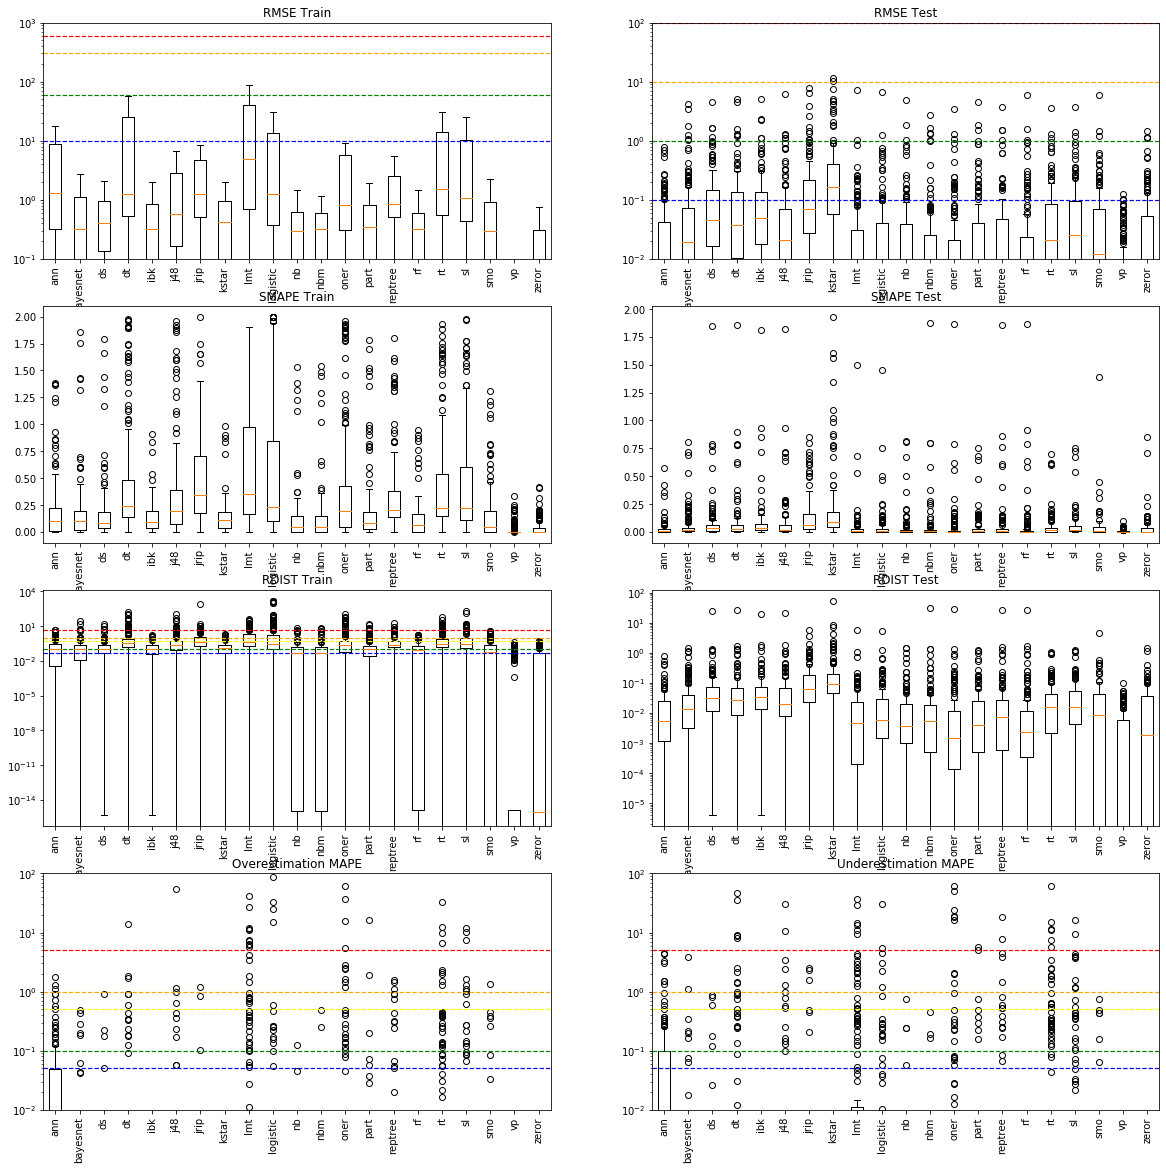

In [53]:
fig, ax = plt.subplots(4,2,figsize=(20,20))
a = ax[0][0]
a.boxplot(metrics["RMSE"]["train"], 0, '')
a.set_xticklabels(classifiers, rotation=90)
a.set_ylim([.1, 1000])
a.set_yscale('log')
a.set_title("RMSE Train")
a.axhline(10, color="blue", linestyle="--", linewidth="1.2")
a.axhline(60, color="green", linestyle="--", linewidth="1.2")
a.axhline(300, color="orange", linestyle="--", linewidth="1.2")
a.axhline(600, color="red", linestyle="--", linewidth="1.2")
a = ax[0][1]
a.boxplot(metrics["RMSE"]["test"])
a.set_xticklabels(classifiers, rotation=90)
a.set_yscale('log')
a.set_ylim([.01, 100])
a.set_title("RMSE Test")
a.axhline(0.1, color="blue", linestyle="--", linewidth="1.2")
a.axhline(1, color="green", linestyle="--", linewidth="1.2")
a.axhline(10, color="orange", linestyle="--", linewidth="1.2")
a.axhline(100, color="red", linestyle="--", linewidth="1.2")
a = ax[1][0]
a.boxplot(metrics["SMAPE"]["train"])
a.set_xticklabels(classifiers, rotation=90)
a.set_title("SMAPE Train")
a = ax[1][1]
a.boxplot(metrics["SMAPE"]["test"])
a.set_xticklabels(classifiers, rotation=90)
a.set_title("SMAPE Test")
a = ax[2][0]
a.boxplot(metrics["RDIST"]["train"])
a.set_xticklabels(classifiers, rotation=90)
a.set_title("RDIST Train")
a.axhline(0.05, color="blue", linestyle="--", linewidth="1.2")
a.axhline(0.1, color="green", linestyle="--", linewidth="1.2")
a.axhline(0.5, color="yellow", linestyle="--", linewidth="1.2")
a.axhline(1, color="orange", linestyle="--", linewidth="1.2")
a.axhline(5, color="red", linestyle="--", linewidth="1.2")
a.set_yscale('log')
a = ax[2][1]
a.boxplot(metrics["RDIST"]["test"])
a.set_xticklabels(classifiers, rotation=90)
a.set_title("RDIST Test")
a.set_yscale('log')

# over MAPE / under MAPE
a = ax[3][0]
a.boxplot(np.maximum(0.000000001, metrics["overMAPE"]["train"]))
a.set_xticklabels(classifiers, rotation=90)
a.set_title("Overestimation MAPE")
a.set_yscale('log')
a.set_ylim([.01, 100])
a.axhline(0.05, color="blue", linestyle="--", linewidth="1.2")
a.axhline(0.1, color="green", linestyle="--", linewidth="1.2")
a.axhline(0.5, color="yellow", linestyle="--", linewidth="1.2")
a.axhline(1, color="orange", linestyle="--", linewidth="1.2")
a.axhline(5, color="red", linestyle="--", linewidth="1.2")
a = ax[3][1]
a.boxplot(np.maximum(0.000000001, metrics["underMAPE"]["train"]))
a.set_xticklabels(classifiers, rotation=90)
a.set_title("Underestimation MAPE")
a.set_yscale('log')
a.set_ylim([.01, 100])
a.axhline(0.05, color="blue", linestyle="--", linewidth="1.2")
a.axhline(0.1, color="green", linestyle="--", linewidth="1.2")
a.axhline(0.5, color="yellow", linestyle="--", linewidth="1.2")
a.axhline(1, color="orange", linestyle="--", linewidth="1.2")
a.axhline(5, color="red", linestyle="--", linewidth="1.2")


## RMSE heatmaps

pass

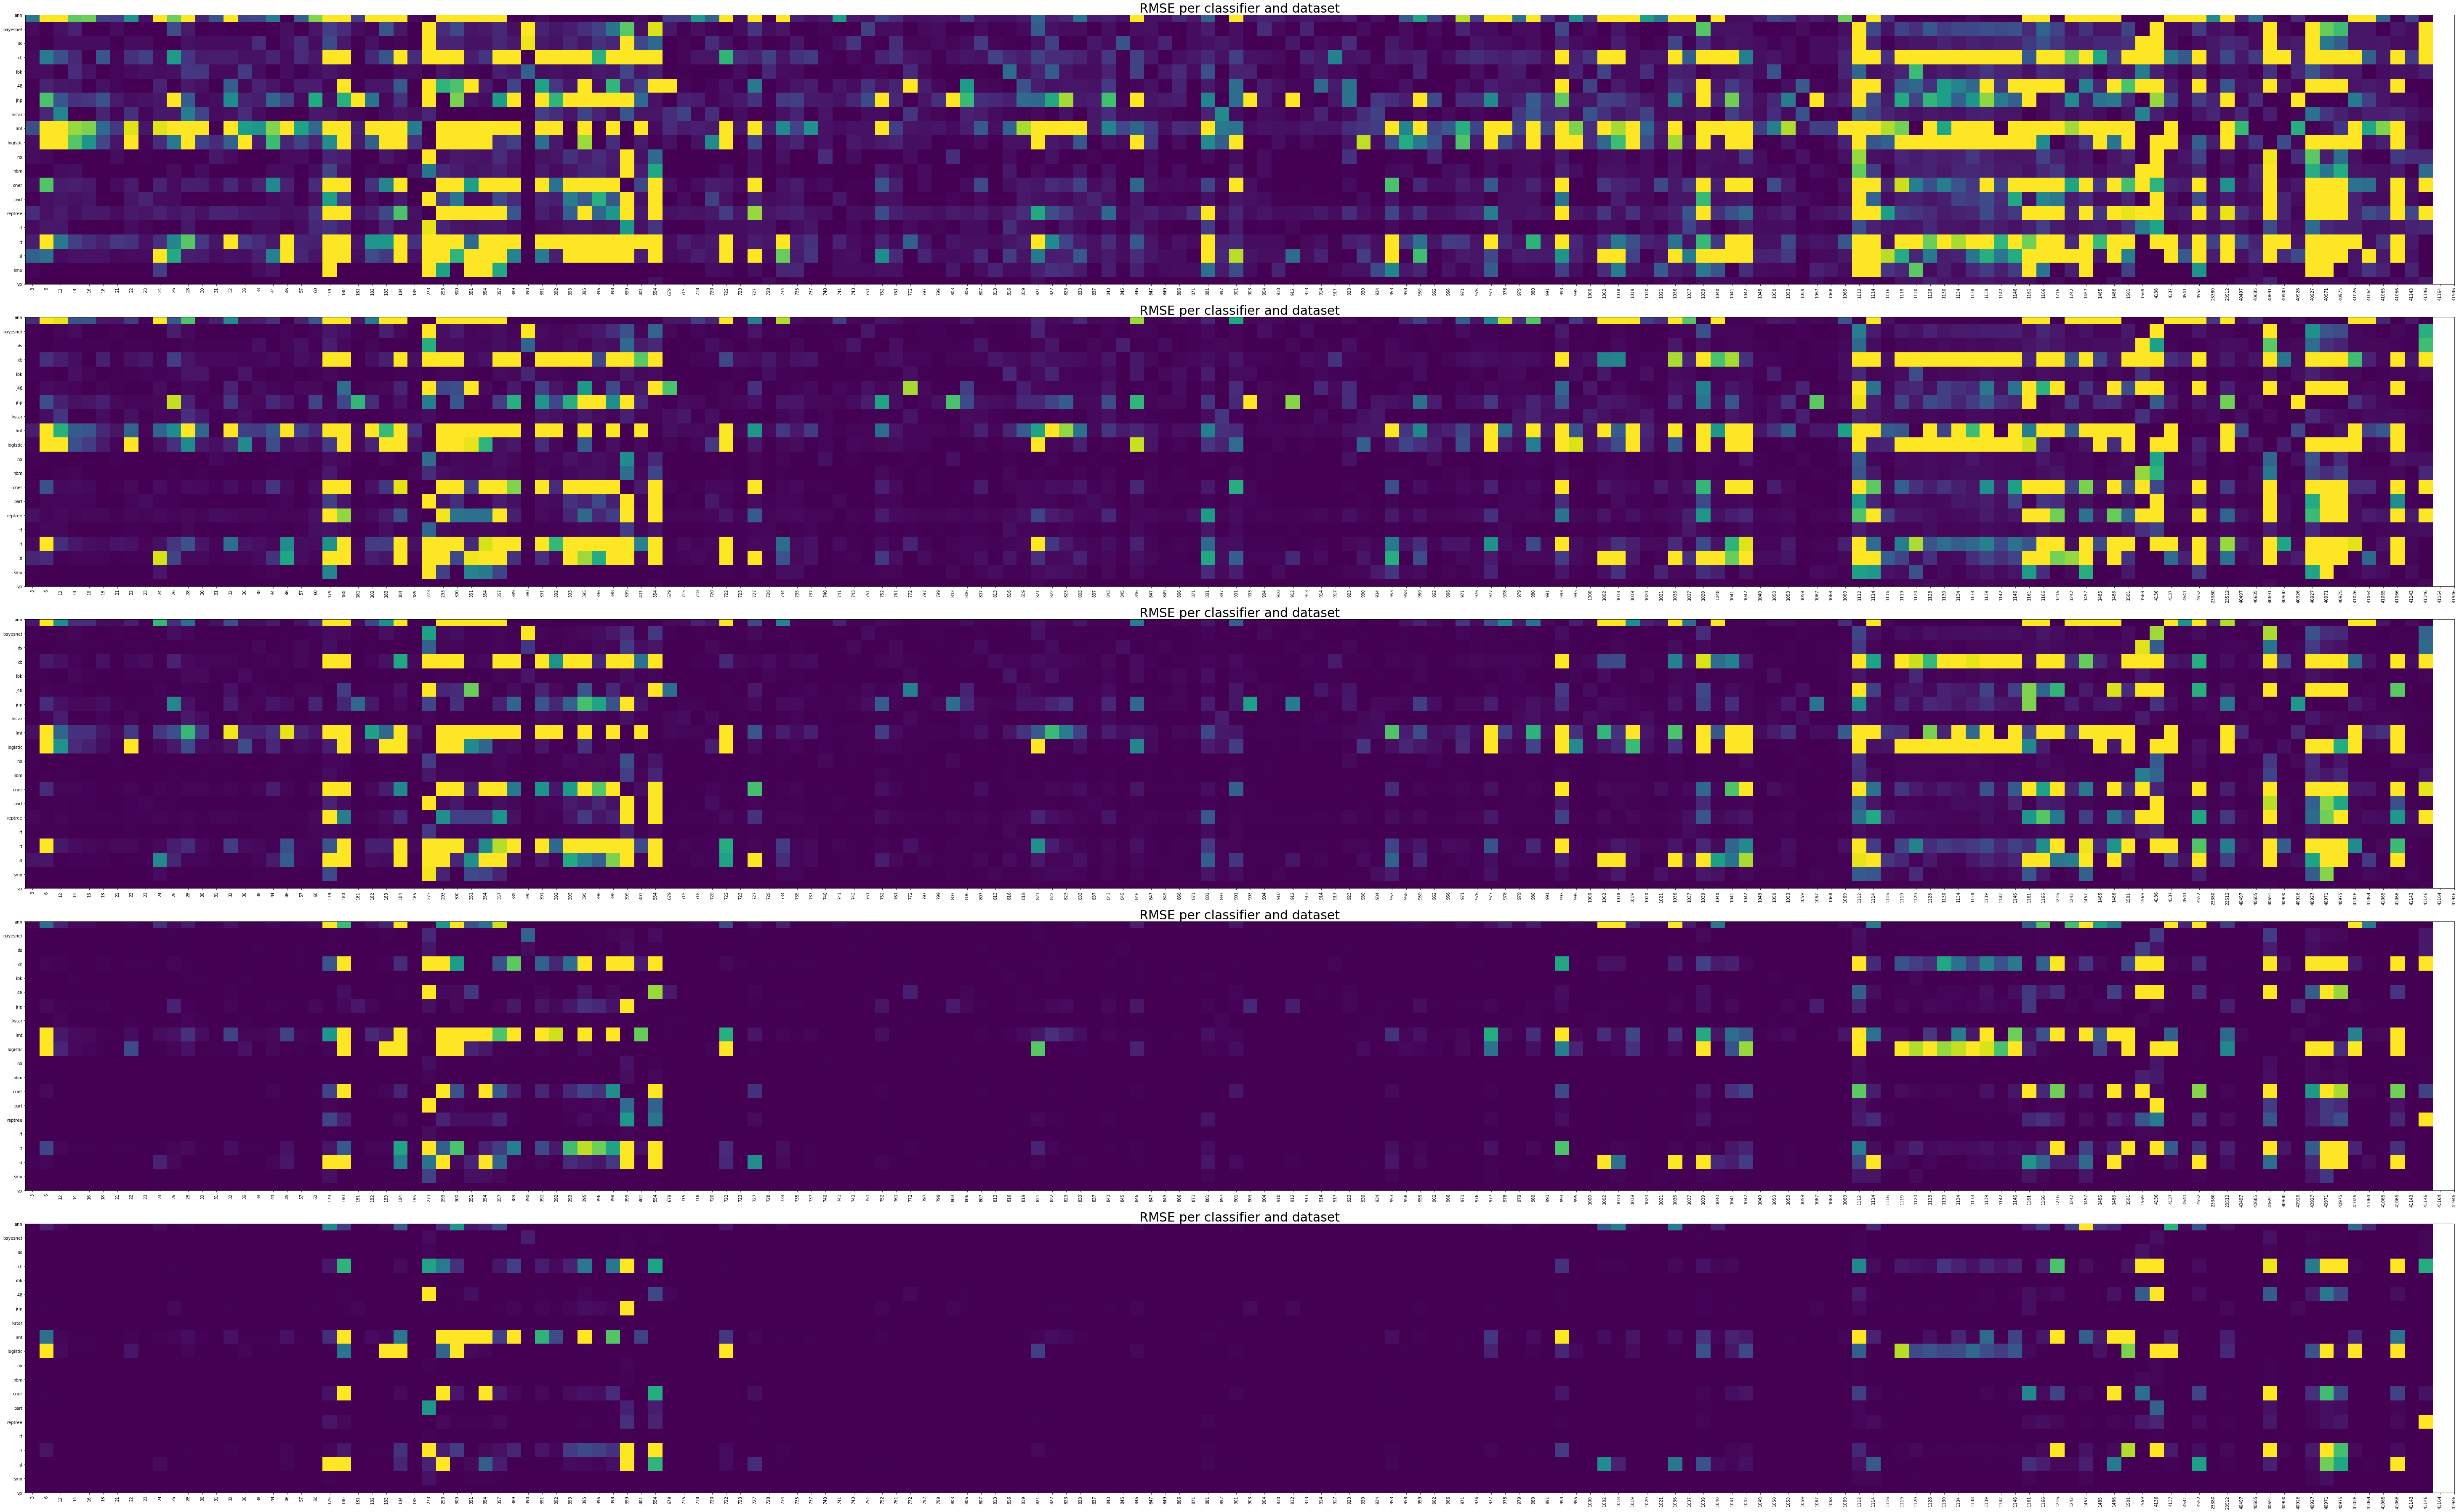

In [91]:
fig, ax = plt.subplots(5, 1, figsize=(5 * 40, 50))
for i, tol in enumerate([10, 30, 60, 300, 1200]):
    a = ax.ravel()[i]
    im = a.imshow(tableMean(metrics["RMSE"]["train"].T), cmap='viridis', vmin=0, vmax=tol)
    a.set_xticks(np.arange(len(datasets) - 1))
    a.set_xticklabels(datasets, rotation=90)
    a.set_yticks(np.arange(len(classifiers) - 1))
    a.set_yticklabels(classifiers)
    a.set_title("RMSE per classifier and dataset", fontsize=30)
fig.tight_layout()
pass

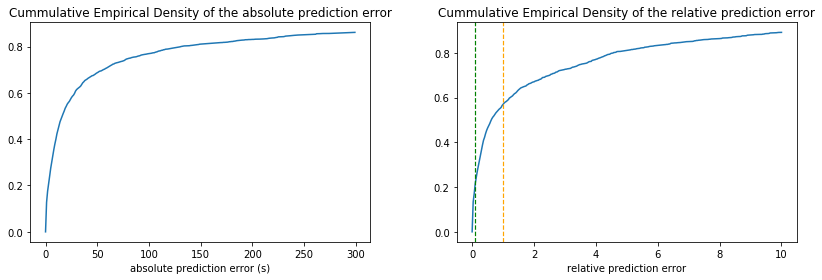

In [144]:
# distribution of mistakes
M = []
N = []
for seedsAndPairs in trainGTPredictionPairs.ravel():
    for pairs in seedsAndPairs:
        for i, gt in enumerate(pairs[0]):
            pr = pairs[1][i]
            if np.max([gt, pr]) >= 10:
                M.append(np.abs(gt - pr))
            if np.max([gt, pr]) >= 10:
                dev = np.abs(gt - pr) / np.min([gt, pr])
                N.append(dev)
               # if dev > 10:
                #    print(str(gt) + "/" + str(pr))
F1 = []
F2 = []
for t in range(300):
    F1.append(len([x for x in M if x <= t]) / len(M))
B2 = np.linspace(0, 10, 300)
for t in B2:
    F2.append(len([x for x in N if x <= t]) / len(N))
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(F1)
ax[0].set_xlabel("absolute prediction error (s)")
ax[0].set_title("Cummulative Empirical Density of the absolute prediction error")
ax[1].plot(B2, F2)
ax[1].set_xlabel("relative prediction error")
ax[1].set_title("Cummulative Empirical Density of the relative prediction error")
ax[1].axvline(0.1, color="green", linestyle="--", linewidth="1.2")
ax[1].axvline(1, color="orange", linestyle="--", linewidth="1.2")
plt.tight_layout()
pass

## 3.2. Percentage of Predictions within a given maximum RMSE

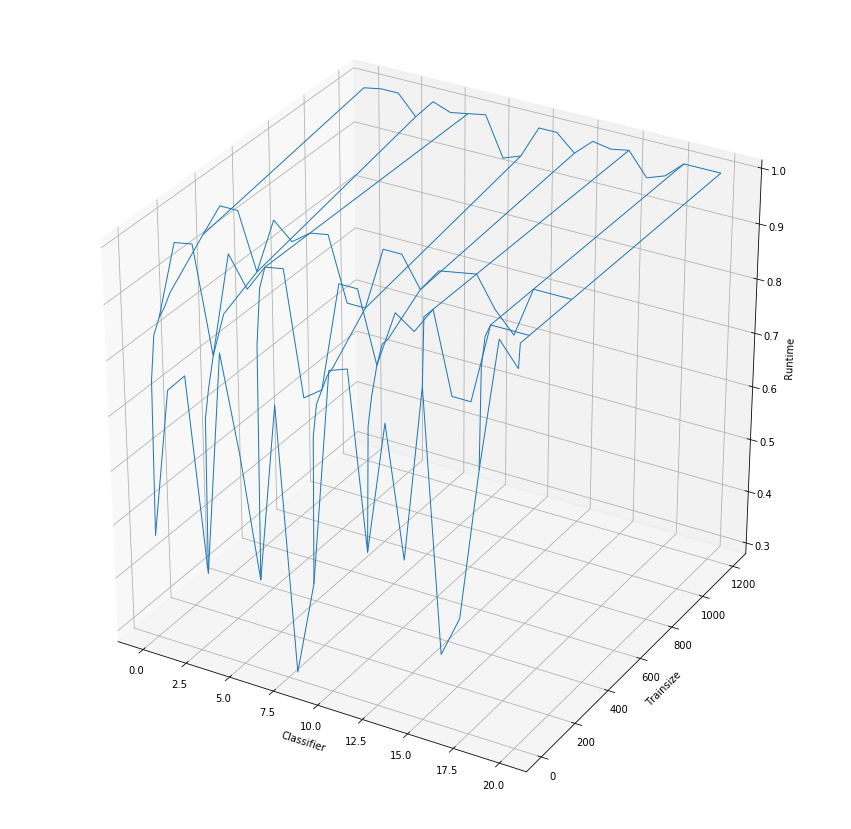

In [83]:
covSpace = [1, 10, 30, 60, 90, 120, 300, 1200]
X, Y = np.meshgrid(range(len(cClassifiers)), covSpace)
trainCoverage = np.zeros((len(covSpace), len(cClassifiers)))
for i, c in enumerate(cClassifiers):
    for j, cov in enumerate(covSpace):
        trainCoverage[j,i] = np.count_nonzero(metrics['RMSE']['train'][:,i] <= cov) / len(metrics['RMSE']['train'][:,i])
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection='3d')
ax.plot_wireframe(X, Y, trainCoverage, rstride=3, cstride=3, linewidth=1, antialiased=True)
ax.set_xlabel('Classifier')
ax.set_ylabel('Trainsize')
ax.set_zlabel('Runtime')
pass

## 3.3. Critical over- and understimations of the predictor
Idea:
* Even large absolute prediction failures are **ok** if both prediction and true runtime are substantially beyond the timeout.
* Prediction failures are a **problem** if the timeout is between prediction and true timeout

We should check the timeout is between prediction and truth when
* the absolute error is large
* the absolute error is small 

In [84]:
def getTotalPairs(pairs):
    c = 0
    for seed in range(len(pairs)):
        c += len(pairs[seed][0])
    return c
    
def retainCriticallyMissEstimations(pairs, timeout):
    reducedPairsOverestimation = []
    reducedPairsUnderestimation = []
    allErrored = []
    if type(pairs) == list and len(pairs) > 0:
        for seed in range(len(pairs)):
            gt = pairs[seed][0]
            pr = pairs[seed][1]
            toArray = np.ravel(np.full((len(gt), 1), to))
            overestimateMiss = np.where((gt < toArray) & (toArray < pr))[0]
            reducedPairsOverestimation.append((gt[overestimateMiss], pr[overestimateMiss]))
            underestimateMiss = np.where((gt > toArray) & (toArray > pr))[0]
            reducedPairsUnderestimation.append((gt[underestimateMiss], pr[underestimateMiss]))
            erroredGT = []
            erroredGT.extend(gt[overestimateMiss])
            erroredGT.extend(gt[underestimateMiss])
            erroredPR = []
            erroredPR.extend(pr[overestimateMiss])
            erroredPR.extend(pr[underestimateMiss])
            allErrored.append((erroredGT, erroredPR))
    return allErrored, reducedPairsOverestimation, reducedPairsUnderestimation

timeouts = np.linspace(10, 1800, 101)
overestimates = np.zeros((len(cClassifiers), len(timeouts), len(dDatasets)))
underestimates = np.zeros((len(cClassifiers), len(timeouts), len(dDatasets)))
for j, c in enumerate(cClassifiers):
    for k, to in enumerate(timeouts):
        for i, d in enumerate(dDatasets):
            if type(trainGTPredictionPairs[i][j]) == list and len(trainGTPredictionPairs[i][j]) > 0:
                allerrored, overpairs, underpairs = retainCriticallyMissEstimations(trainGTPredictionPairs[i][j], to)
                for seed in range(len(overpairs)):
                    overestimates[j][k][i] += len(overpairs[seed][0])
                    underestimates[j][k][i] += len(underpairs[seed][0])
                totalCounts = getTotalPairs(trainGTPredictionPairs[i][j])
                if totalCounts < overestimates[j][k][i] or totalCounts < overestimates[j][k][i]:
                    raise Exception("Cannot have more over/underestimates than counts")
                overestimates[j][k][i] /= totalCounts
                underestimates[j][k][i] /= totalCounts

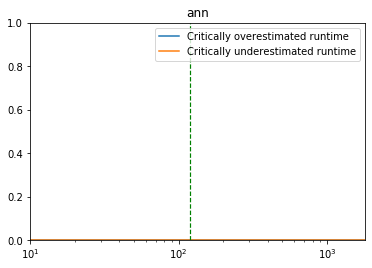

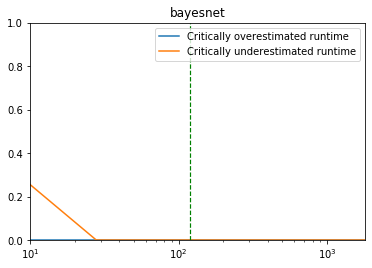

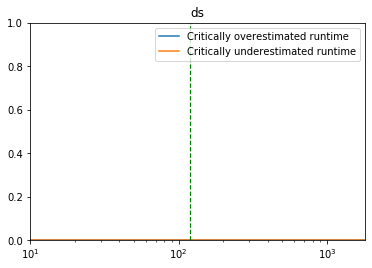

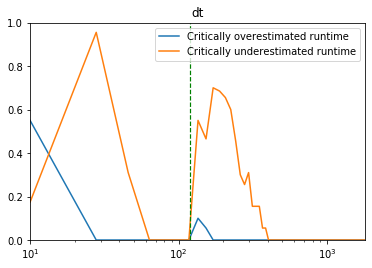

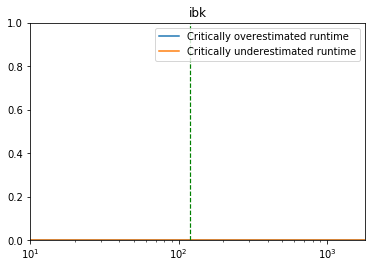

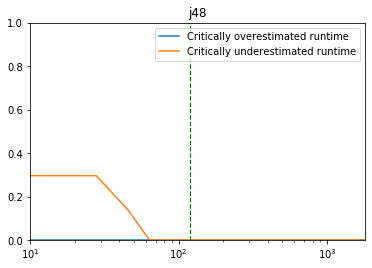

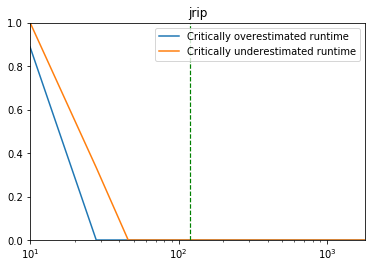

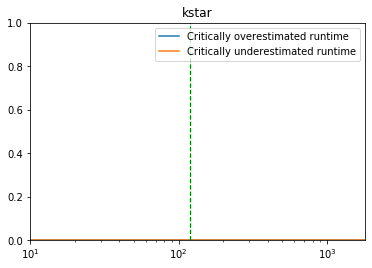

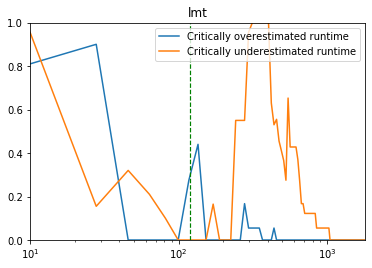

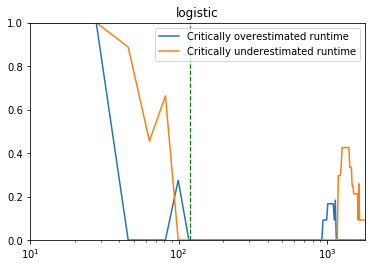

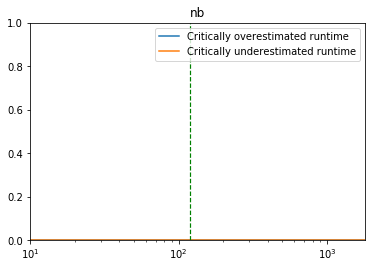

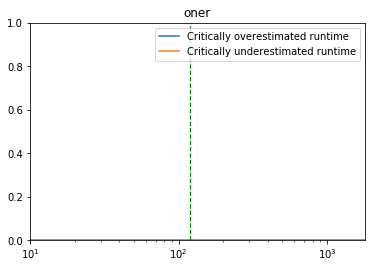

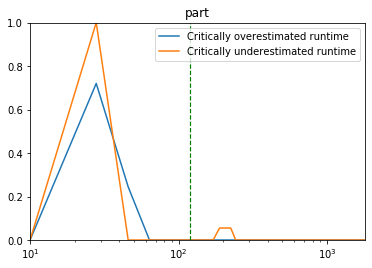

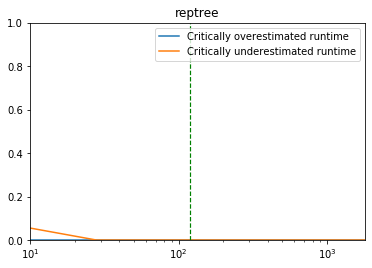

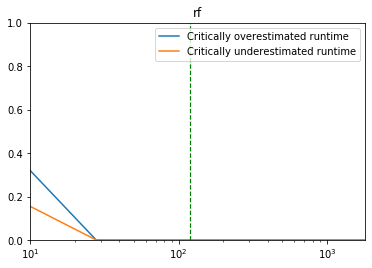

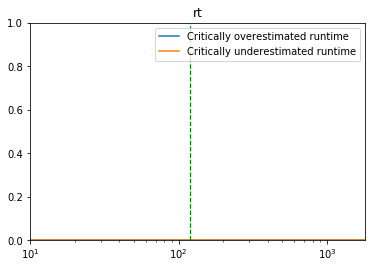

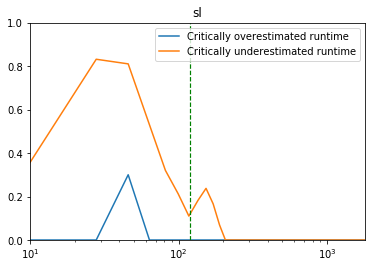

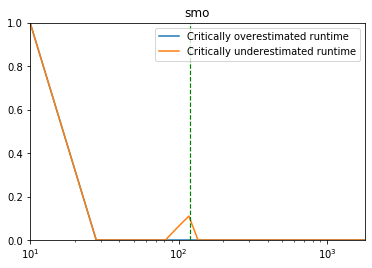

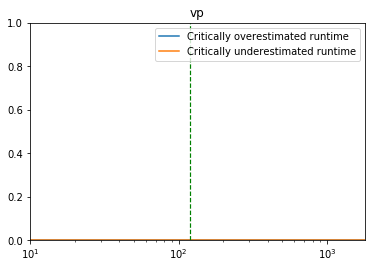

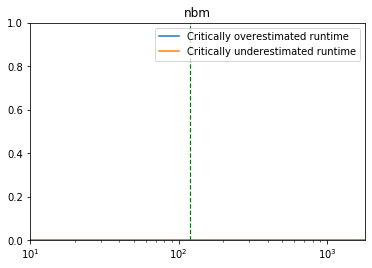

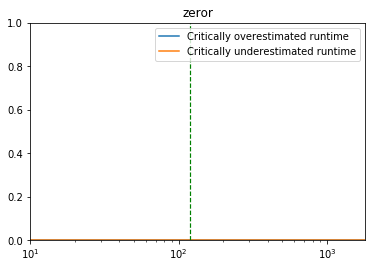

In [85]:
for i, c in enumerate(cClassifiers):
    plt.figure()
    plt.plot(timeouts, np.quantile(overestimates[i], .95, axis=1))
    plt.plot(timeouts, np.quantile(underestimates[i], .95, axis=1))
    plt.title(c)
    #plt.yscale("log")
    plt.xlim([10,1800])
    plt.ylim([0,1])
    plt.xscale("log")
    plt.axvline(120, color="green", linestyle="--", linewidth="1.2")
    plt.legend(["Critically overestimated runtime", "Critically underestimated runtime"])
    plt.show()
    plt.close()

**Conclusion**: In my view, the above results say the following: For a timeout of 2 minutes or more, the risk that a critical error occurs in the prediction is quite small (less than 5% except on decision tables). Of course, there may still be errors. But typically these are not crtitical with respect to executability.

**Note**: We have not considered a conservative prediction here (assuming e.g. runtime up to 2 times higher than the one predicted).

## 3.4. Can we predict whether the predict will (substantially) overestimate or underestimate?

In [86]:
pDatasets, pClassifiers, pTrainDiff, pPredictDiff = dDatasets, cClassifiers, trainGTPredictionPairs, testGTPredictionPairs

In [88]:
relevantAttributes = ["openmlid", "classifier", "seed", "fitsize", "factor", 'numattributes', 'numlabels', 'numnumericattributes',
       'numsymbolicattributes', 'numberofcategories',
       'numericattributesafterbinarization', 'attributestocover50pctvariance',
       'attributestocover90pctvariance', 'attributestocover95pctvariance',
       'attributestocover99pctvariance', 'accvariancerel1', 'accvariancerel2',
       'accvariancerel3', 'accvariancerel4', 'accvariancerel5',
       'accvariancerel6', 'accvariancerel7', 'accvariancerel8',
       'accvariancerel9', 'accvariancerel10', 'accvarianceabs1',
       'accvarianceabs2', 'accvarianceabs3', 'accvarianceabs4',
       'accvarianceabs5', 'accvarianceabs6', 'accvarianceabs7',
       'accvarianceabs8', 'accvarianceabs9', 'accvarianceabs10',
       'totalvariance', "overestimated"]

In [89]:
overestimateDF = pd.DataFrame(columns=["openmlid", "classifier", "seed", "factor", "overestimated"])
underestimateDF = pd.DataFrame(columns=["openmlid", "classifier", "seed", "factor", "underestimated"])
for f in range(1):
    f += 1
    print(f)
    for i, d in enumerate(tqdm(pDatasets)):
        for j, c in enumerate(pClassifiers):
            for seed in range(len(pTrainDiff[i][j])):
                for k, pr in enumerate(pTrainDiff[i][j][seed][1]):
                    gt = pTrainDiff[i][j][seed][0][k]
                    if pr >= gt:
                        MAPE = (pr - gt)/ gt
                        if MAPE > f:
                            overestimateDF.loc[len(overestimateDF)] = [d, c, seed, f, 1]
                        else:
                            overestimateDF.loc[len(overestimateDF)] = [d, c, seed, f, 0]
                    if pr <= gt:
                        MAPE = (gt - pr)/ pr
                        if MAPE > f:
                            underestimateDF.loc[len(underestimateDF)] = [d, c, seed, f, 1]
                        else:
                            underestimateDF.loc[len(underestimateDF)] = [d, c, seed, f, 0]

1


In [195]:
pDF = underestimateDF.query("factor == 1").merge(mfdf, on=["openmlid", "classifier", "seed"])

In [206]:
underestimateDF.drop_duplicates().query("classifier == 'ann' and seed == 0")

openmlid classifier seed factor underestimated
0        41066        ann    0      1              0
419          3        ann    0      1              0
421          3        ann    0      1              1
459         31        ann    0      1              1
489         60        ann    0      1              0
...        ...        ...  ...    ...            ...
17497     1067        ann    0      2              1
17526     1069        ann    0      2              0
17551     1119        ann    0      2              0
17588     1120        ann    0      2              0
17624    41066        ann    0      3              0

[307 rows x 5 columns]

In [196]:
estData = pd.DataFrame()
for d in tqdm(datasets):
    maxTrainpoints = np.max(pDF.query("openmlid == " + str(d[0]))["trainpoints"])
    if not np.isnan(maxTrainpoints):
        estData = pd.concat([estData, pDF.query("openmlid == " + str(d[0]) + " and trainpoints == " +str(maxTrainpoints)).drop_duplicates()])

In [197]:
## Overstestimation predictor
for c in np.unique(estData["classifier"]):
    tdDF = estData.query("classifier == '" + c + "' and factor == 1")
    rf = sk.ensemble.RandomForestClassifier(n_estimators=100)
    #print(tdDF.columns)
    X = tdDF[["trainpoints", 'numericattributesafterbinarization']].values
    Y = tdDF["underestimated"].values.astype("int")
    print(c + ": " + str(np.mean(sk.model_selection.cross_validate(rf, X, Y, cv=10)["test_score"])))

ann: 0.4797794117647058
bayesnet: 0.6993006993006994
ds: 0.6700549450549451
dt: 0.5328022875816993
ibk: 0.6141025641025641


/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 8 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


j48: 0.6666666666666666


/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


jrip: 0.8166666666666667
kstar: 0.5038461538461538
lmt: 0.5110989010989011
logistic: 0.5276190476190475
nb: 0.6144444444444445


/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


nbm: 0.9800000000000001
oner: 0.7925252525252526
part: 0.6972610722610723
reptree: 0.6143939393939395
rf: 0.6687426900584794
rt: 0.6416666666666667
sl: 0.5795751633986927
smo: 0.5933333333333334
vp: 0.5844444444444445
zeror: 0.8200000000000001


# 3.x. Learning Curves for Basic Algorithms

In [62]:
mfdf

openmlid  datapoints_x  trainpoints  testpoints  seed classifier  \
0          41066          1567            2        1565     0   bayesnet   
1          41066          1567            2        1565     0         ds   
2          41066          1567            2        1565     0         dt   
3          41066          1567            2        1565     0        ibk   
4          41066          1567            2        1565     0      kstar   
...          ...           ...          ...         ...   ...        ...   
297746      1120         19020         5000       14020     5      kstar   
297747      1120         19020         5000       14020     7         ds   
297748      1120         19020         5000       14020     7         dt   
297749      1120         19020         5000       14020     7        ibk   
297750      1120         19020         5000       14020     7      kstar   

        traintime  testtime  datapoints_y  numinstances  ...  accvarianceabs3  \
0             1.0       2.0             2           2.0  ...     5.663569e+06   
1             1.0      68.0             2           2.0  ...     5.663569e+06   
2             1.0      80.0             2           2.0  ...     5.663569e+06   
3             1.0      42.0             2           2.0  ...     5.663569e+06   
4             1.0       2.0             2           2.0  ...     5.663569e+06   
...           ...       ...           ...           ...  ...              ...   
297746        1.0    2619.0          5000        5000.0  ...     3.131044e+07   
297747        1.0       1.0          5000        5000.0  ...     3.129756e+07   
297748        1.0       7.0          5000        5000.0  ...     3.129756e+07   
297749        1.0       8.0          5000        5000.0  ...     3.129756e+07   
297750        1.0    2907.0          5000        5000.0  ...     3.129756e+07   

        accvarianceabs4  accvarianceabs5  accvarianceabs6  accvarianceabs7  \
0          5.940430e+06     6.148597e+06     6.286460e+06     6.408824e+06   
1          5.940430e+06     6.148597e+06     6.286460e+06     6.408824e+06   
2          5.940430e+06     6.148597e+06     6.286460e+06     6.408824e+06   
3          5.940430e+06     6.148597e+06     6.286460e+06     6.408824e+06   
4          5.940430e+06     6.148597e+06     6.286460e+06     6.408824e+06   
...                 ...              ...              ...              ...   
297746     3.131310e+07     3.131489e+07     3.131556e+07     3.131599e+07   
297747     3.130022e+07     3.130201e+07     3.130268e+07     3.130311e+07   
297748     3.130022e+07     3.130201e+07     3.130268e+07     3.130311e+07   
297749     3.130022e+07     3.130201e+07     3.130268e+07     3.130311e+07   
297750     3.130022e+07     3.130201e+07     3.130268e+07     3.130311e+07   

        accvarianceabs8  accvarianceabs9  accvarianceabs10  totalvariance  \
0          6.526566e+06     6.630078e+06      6.677203e+06   7.077074e+06   
1          6.526566e+06     6.630078e+06      6.677203e+06   7.077074e+06   
2          6.526566e+06     6.630078e+06      6.677203e+06   7.077074e+06   
3          6.526566e+06     6.630078e+06      6.677203e+06   7.077074e+06   
4          6.526566e+06     6.630078e+06      6.677203e+06   7.077074e+06   
...                 ...              ...               ...            ...   
297746     3.131634e+07     3.131634e+07      3.131634e+07   3.131634e+07   
297747     3.130346e+07     3.130346e+07      3.130346e+07   3.130346e+07   
297748     3.130346e+07     3.130346e+07      3.130346e+07   3.130346e+07   
297749     3.130346e+07     3.130346e+07      3.130346e+07   3.130346e+07   
297750     3.130346e+07     3.130346e+07      3.130346e+07   3.130346e+07   

        testtimeperinstance  
0                  0.001278  
1                  0.043450  
2                  0.051118  
3                  0.026837  
4                  0.001278  
...                     ...  
297746             0.186805  
297747             0

# 4. Posterior Runtime Prediction of Parametrized Algorithms

In [2]:
mfdf = pd.read_csv("data/metafeatures.csv", delimiter=";")
mfdf

dsv_id  openmlid  datapoints_fold1  datapoints_fold2  attributes  seed  \
0           1      1501                75              1518         NaN     5   
1           2     40975              1500               228         NaN     8   
2           3      1501                75              1518         NaN     6   
3           4     40975              1500               228         NaN     9   
4           5      1501                75              1518         NaN     3   
...       ...       ...               ...               ...         ...   ...   
44625   47696       914               300              1701         NaN     1   
44626   47697        57              1500              2272         NaN     1   
44627   47698        57              1500              2272         NaN     0   
44628   47699        57              1500              2272         NaN     3   
44629   47700        57              1500              2272         NaN     2   

       f1_numinstances  f1_numattributes  f1_numlabels  \
0                 75.0             256.0          10.0   
1               1500.0               6.0           4.0   
2                 75.0             256.0          10.0   
3               1500.0               6.0           4.0   
4                 75.0             256.0          10.0   
...                ...               ...           ...   
44625            300.0               2.0           2.0   
44626           1500.0              29.0           4.0   
44627           1500.0              29.0           4.0   
44628           1500.0              29.0           4.0   
44629           1500.0              29.0           3.0   

       f1_numnumericattributes  ...  f2_accvarianceabs2  f2_accvarianceabs3  \
0                        256.0  ...            0.499994            0.749843   
1                          0.0  ...            0.454865            0.679515   
2                        256.0  ...            0.499982            0.749806   
3                          0.0  ...            0.467385            0.698702   
4                        256.0  ...            0.499933            0.749804   
...                        ...  ...                 ...                 ...   
44625                      2.0  ...       243214.355619       243214.355619   
44626                      7.0  ...         4084.585121         4625.928315   
44627                      7.0  ...         3890.911616         4402.000676   
44628                      7.0  ...         4038.926080         4624.025107   
44629                      7.0  ...         3887.394896         4546.928173   

       f2_accvarianceabs4  f2_accvarianceabs5  f2_accvarianceabs6  \
0                0.998694            1.247497            1.496201   
1                0.904166            1.125879            1.347593   
2                0.998705            1.247556            1.496209   
3                0.928762            1.153412            1.376613   
4                0.998655            1.247458            1.496162   
...                   ...                 ...                 ...   
44625       243214.355619       243214.355619       243214.355619   
44626         4983.182566         4984.448994         4984.691274   
44627         4832.537139         4833.765406         4834.007291   
44628         4983.426110         4984.583559         4984.827666   
44629         4980.847088         4982.035664         4982.274796   

       f2_accvarianceabs7  f2_accvarianceabs8  f2_accvarianceabs9  \
0                1.744114            1.991288            2.238013   
1                1.567780            1.787967            2.008154   
2                1.744123            1.991438            2.238316   
3                1.588589            1.800564            2.008984   
4                1.744013            1.991398            2.238123   
...                   ...                 ...                 ...   
44625       243214.355619       243214.355619       243214.355619   
44626  

In [292]:
def getBaselearnerRuntimes(algorithm):
    df = pd.read_csv("data/runtimes_all_parametrized.csv").query("algorithm == '" + algorithm + "'")
    if len(df) == 0:
        raise Exception("No data available for algorithm " + algorithn)
    
    attributes = None
    
    if algorithm == 'ann':
        attributes = ["B", "R", "C", "D", "L", "M", "H_i", "H_o", "H_t", "H_a"]
        for a in ["B", "R", "C", "D"]:
            df[a] = [ 1 if ("-" + a) in s else 0 for s in df["algorithmoptions"].values]
        df["L"] = [float(x.split(" ")[-1]) if "-L" in x else 0.3 for x in df["algorithmoptions"]]
        df["M"] = [float(x.split(" ")[-1]) if "-M" in x else 0.2 for x in df["algorithmoptions"]]
        df["H_i"] = [ 1 if "-H i" in s else 0 for s in df["algorithmoptions"].values]
        df["H_o"] = [ 1 if "-H o" in s else 0 for s in df["algorithmoptions"].values]
        df["H_t"] = [ 1 if "-H t" in s else 0 for s in df["algorithmoptions"].values]
        df["H_a"] = 1 - np.maximum(df["H_i"], np.maximum(df["H_o"], df["H_t"]))
        
    if algorithm == 'bayesnet':
        attributes = ['D', 'Q_K2', 'Q_Tabu', 'Q_SA', 'Q_LAGDHC', 'Q_TAN', 'Q_HC']
        df["D"] = [ 1 if "-D" in s else 0 for s in df["algorithmoptions"].values]
        df["Q_K2"] = [ 1 if "-Q weka.classifiers.bayes.net.search.local.K2" in s else 0 for s in df["algorithmoptions"].values]
        df["Q_Tabu"] = [ 1 if "-Q weka.classifiers.bayes.net.search.local.TabuSearch" in s else 0 for s in df["algorithmoptions"].values]
        df["Q_SA"] = [ 1 if "-Q weka.classifiers.bayes.net.search.local.SimulatedAnnealing" in s else 0 for s in df["algorithmoptions"].values]
        df["Q_LAGDHC"] = [ 1 if "-Q weka.classifiers.bayes.net.search.local.LAGDHillClimber" in s else 0 for s in df["algorithmoptions"].values]
        df["Q_TAN"] = [ 1 if "-Q weka.classifiers.bayes.net.search.local.TAN" in s else 0 for s in df["algorithmoptions"].values]
        df["Q_HC"] = [ 1 if "-Q weka.classifiers.bayes.net.search.local.HillClimber" in s else 0 for s in df["algorithmoptions"].values]
    
    if algorithm == 'lmt':
        attributes = ["B", "R", "C", "P", "A", "M", "W"]
        for a in ["B", "R", "C", "P", "A"]:
            df[a] = [ 1 if ("-" + a) in s else 0 for s in df["algorithmoptions"].values]
        df["M"] = [float(x.split(" ")[-1]) if "-M" in x else 15 for x in df["algorithmoptions"]]
        df["W"] = [float(x.split(" ")[-1]) if "-W" in x else 0 for x in df["algorithmoptions"]]
        
    if attributes == None:
        return pd.DataFrame()
    
    df = df.merge(mfdf, left_on=["openmlid", "fitsize", "seed"], right_on=["openmlid", "datapoints_fold1", "seed"])
    projection = ["openmlid", "fitsize", "seed"]
    projection.extend(attributes)
    projection.extend(['f1_numericattributesafterbinarization', 'fittime', 'applicationtime'])
    df = df[projection].rename(columns={"f1_numericattributesafterbinarization" : "numericattributesafterbinarization"})
    
    # now load default runtimes for this classifier
    defDF = pd.read_csv("data/runtimes_all_default.csv").query("algorithm == '" + algorithm + "'")[["openmlid", "fitsize", "seed", "fittime"]].rename(columns={"fittime": "fittime_def"})
    
    # merge the two tables
    df = df.merge(defDF, left_on=["openmlid", "fitsize", "seed"], right_on=["openmlid", "fitsize", "seed"])
    return df

In [293]:
df = getBaselearnerRuntimes("lmt")
df

openmlid  fitsize  seed  B  R  C  P  A     M    W  \
0            6      100     2  1  0  0  0  0  15.0  0.0   
1            6      100     2  0  1  0  0  0  15.0  0.0   
2            6      100     2  0  0  1  0  0  15.0  0.0   
3            6      100     2  0  0  0  1  0  15.0  0.0   
4            6      100     2  0  0  0  0  1  15.0  0.0   
...        ...      ...   ... .. .. .. .. ..   ...  ...   
8945     41164      100     4  0  0  0  0  0  15.0  4.0   
8946     41991    10000     0  0  1  0  0  0  15.0  0.0   
8947     41991    10000     0  0  0  1  0  0  15.0  0.0   
8948     41991    10000     0  0  0  0  1  0  15.0  0.0   
8949     41991    10000     1  0  0  0  0  0  64.0  0.0   

      numericattributesafterbinarization  fittime  applicationtime  \
0                                   16.0        2              3.0   
1                                   16.0        1              4.0   
2                                   16.0        5              4.0   
3                                   16.0        3              3.0   
4                                   16.0        2              3.0   
...                                  ...      ...              ...   
8945                               800.0        5             11.0   
8946                               784.0     3601              NaN   
8947                               784.0     3601              NaN   
8948                               784.0     3600              NaN   
8949                               784.0     3600              NaN   

      fittime_def  
0               2  
1               2  
2               2  
3               2  
4               2  
...           ...  
8945            6  
8946         3601  
8947         3601  
8948         3601  
8949         3608  

[8950 rows x 14 columns]

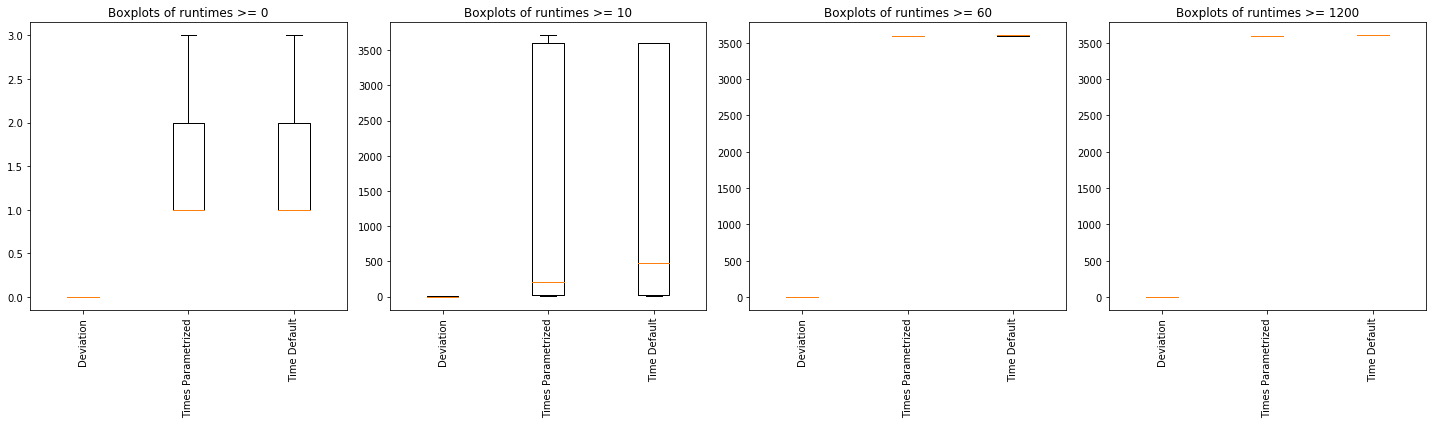

In [294]:
fig, ax = plt.subplots(1, 4, figsize = (20, 6))
for i, t in enumerate([0, 10, 60, 1200]):
    eDF = df.query("fittime >= " + str(t))
    a = np.ravel(ax)[i]
    M = ((eDF["fittime"] - eDF["fittime_def"])).dropna().values
    a.boxplot([M, eDF["fittime"], eDF["fittime_def"].dropna().values], 0, '')
    a.set_title("Boxplots of runtimes >= " + str(t))
    a.set_xticklabels(["Deviation", "Times Parametrized", "Time Default"], rotation=90)
fig.tight_layout()
pass

In [260]:
def getParametrizedAlgoPredictionRMSE(df, algorithm):
    datasets = pd.unique(df["openmlid"])

    # partition attributes into basic ones and algorithm specific ones
    XattsBasic = ['fitsize', 'numericattributesafterbinarization']
    XattsAlgorithmSpecific = list(df.columns)
    for f in XattsBasic:
        XattsAlgorithmSpecific.remove(f)
    for f in ['openmlid', 'seed', 'fittime', 'applicationtime', 'fittime_def']:
        XattsAlgorithmSpecific.remove(f)

    cDF = pd.DataFrame([], columns=["openmlid", "algorithm", "fitsize", "without", "with"])
    withoutCol = list(cDF.columns).index("without")
    pbar = tqdm(total = len(datasets) * 2 * 3)
    for d in datasets:
        trainDF = df.query("openmlid != " + str(d))
        testDF = df.query("openmlid == " + str(d))
        if len(trainDF) > 0 and len(testDF) > 0:
            for mode in ["with", "without"]:
                Xatts = XattsBasic.copy()
                if mode == "with":
                    Xatts.extend(XattsAlgorithmSpecific)
                    Xatts.append("fittime_def")

                Xtrain = trainDF[trainDF['fittime_def'].notna()][Xatts].values
                Ytrain = trainDF[trainDF['fittime_def'].notna()]["fittime"].values
                rf = RandomForestRegressor(n_estimators=1)
                rf.fit(Xtrain, Ytrain)

                datapoints = pd.unique(testDF["fitsize"])
                #print(d)
                for tp in [1000, 10000, 100000]:
                    Xtest = testDF[testDF['fittime_def'].notna()].query("fitsize == " + str(tp))[Xatts].values
                    Ytest = testDF[testDF['fittime_def'].notna()].query("fitsize == " + str(tp))["fittime"].values
                    if len(Xtest) > 0:
                        predictions = rf.predict(Xtest)
                        score = np.sqrt(sk.metrics.mean_squared_error(Ytest, predictions))
                        output.append(score)
                        if mode == "with":
                            cDF.loc[len(cDF)] = [d, algorithm, tp, "", score]
                        else:
                            index = cDF.query("openmlid == " + str(d) + " and algorithm == '" + algorithm + "' and fitsize == " + str(tp)).index[0]
                            cDF.at[index,"without"] = score
                        #print("\t" + str(tp) + ": " + str(score) + " (abs average = " + str(np.mean(Ytest)) + ")")
                    pbar.update(1)
    pbar.close()
    return cDF

In [223]:
comparisons = {}

In [295]:
for c in classifiers:
    if not c in comparisons:
        print(c)
        cDF = getBaselearnerRuntimes(c)
        if len(cDF) > 0:
            comparisons[c] = getParametrizedAlgoPredictionRMSE(cDF, c)

lmt


In [308]:
D = np.zeros((len(classifiers), len(datasets)))
R = np.zeros((len(classifiers), len(datasets)))
for i, d in enumerate(datasets):
    for j, c in enumerate(classifiers):
        if c in comparisons:
            valsWith = comparisons[c].query("openmlid == " + str(d))["with"].values
            valsWithout = comparisons[c].query("openmlid == " + str(d))["without"].values
            Dx = np.array(valsWith) - np.array(valsWithout).astype(float)
            Rx = np.array([0 if x < 10 else (x - valsWith[k]) / x for k, x in enumerate(valsWithout)]).astype(float)
            D[j][i] = np.mean(Dx) if len(Dx) > 0 else 0
            R[j][i] = np.mean(Rx) if len(Rx) > 0 else 0
        else:
            pass

Text(0.5, 1.0, 'Relative reduction of RMSE')

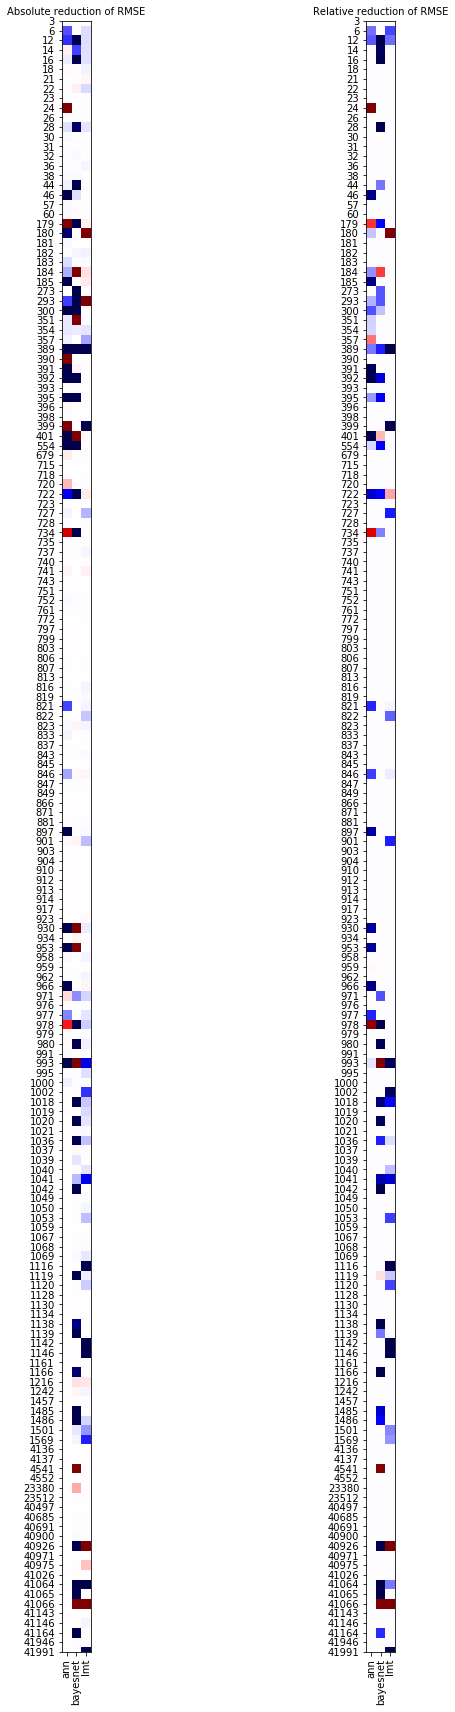

In [313]:
fig, ax = plt.subplots(1,2, figsize=(10, 30))
a = ax[0]
im = a.imshow(M.T, cmap='seismic', vmin=-60, vmax=60)
a.set_yticks(np.arange(len(datasets)))
a.set_yticklabels(datasets)
a.set_xticks(np.arange(len(classifiers)))
a.set_xticklabels(classifiers, rotation=90)
a.set_title("Absolute reduction of RMSE", fontsize=10)

a = ax[1]
im = a.imshow(R.T * -1, cmap='seismic', vmin=-1, vmax=1)
a.set_yticks(np.arange(len(datasets)))
a.set_yticklabels(datasets)
a.set_xticks(np.arange(len(classifiers)))
a.set_xticklabels(classifiers, rotation=90)
a.set_title("Relative reduction of RMSE", fontsize=10)

In [277]:
valsWith = comparisons['ann']["with"].values
valsWithout = comparisons['ann']["without"].values
D = np.array(valsWith) - np.array(valsWithout).astype(float)
R = np.array([0 if x < 10 else (x - valsWith[i]) / x for i, x in enumerate(valsWithout)]).astype(float)

TypeError: unhashable type: 'slice'

ValueError: x and y must be the same size

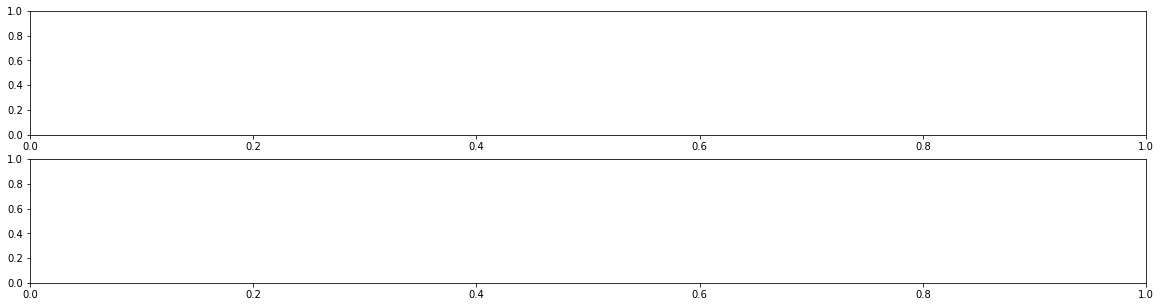

In [310]:
#fig, ax = plt.subplots(2, 1, figsize=(20, 5))
#ax[0].scatter(range(len(D)), np.array(valsWith))
#ax[0].scatter(range(len(D)), np.array(valsWithout))
#ax[0].set_yscale("log")
#ax[0].set_ylim([0.01, 10000])
ax[0].legend(["with", "without"])
ax[1].scatter(range(len(D)), D)
